In [4]:
import os
import sys
#sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from imutils import paths
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random
import pickle
import csv

!export PATH=/Library/TeX/texbin:$PATH

feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
#imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\001\\images\\"
#coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-1-shufflenet.csv'
#imgPath = '/home/src21/Downloads/Bakul-All/005/images'

imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\002_new\\images\\"
coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-2new-shufflenet.csv'

windowCount = 0

# Displaying the contents of the text file

# del list

with open(coordFilePath, newline='') as f:
    csvread = csv.reader(f)
    print(csvread)
    batch_data = list(csvread)
print(len(batch_data))

print(batch_data[0])


batch_data_int = []
for inner_list in batch_data:
    innet_out_list = []
    for string in inner_list:
        innet_out_list.append(int(float(string)))
    batch_data_int.append(innet_out_list)

print("bATCH_Data_int:", batch_data_int)
print(len(batch_data_int))
print(batch_data_int[1][0])
FinalList = []
for i in range(len(batch_data_int)):
    el = batch_data_int[i]
    elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
    print("elChunks:", elChunks)
    newElChunks = elChunks.copy()
    for i in range(len(elChunks)):
#         newChunk = newElChunks[i]        
        chunk = elChunks[i]
        newChunk = chunk.copy()
        print("newChunk", newChunk)
        print("chunk", chunk)
        newChunk.insert(2, chunk[0])
        newChunk.insert(3, chunk[3])
        newChunk.insert(6, chunk[2])
        newChunk.insert(7, chunk[1])
        print("newModifiedChunk", newChunk)
        newElChunks[i] = newChunk
    print(newElChunks)
    perImageCoords = np.array(newElChunks)
    perImageCoords = perImageCoords.reshape(-1,4,2)
    FinalList.append(perImageCoords)

print("Final list:", FinalList)
print("Final list size:", len(FinalList))
print("Final list:", FinalList[0].shape)
print("Final list:", FinalList[0])

def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(img_gray, coordinates, padding = 5):
    ret, binary_img = cv2.threshold(img_gray, 255, 255, cv2.THRESH_BINARY)
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

def mapToPick(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

def mapToPickv1(coordinates, padding = 5):
    pick = []
    for i in range(coordinates.shape[0]):
#         startX, startY = coordinates[i][0]
#         endX, endY = coordinates[i][2]
        startX, endX, startY, endY = calculateRange(coordinates[i], padding, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick
    

print(FinalList[-1])
ans = mapToPickv1(FinalList[-1])
print(ans)

9
['2.090000000000000000e+02', '1.270000000000000000e+02', '4.110000000000000000e+02', '3.120000000000000000e+02', '6.260000000000000000e+02', '1.270000000000000000e+02', '8.260000000000000000e+02', '3.100000000000000000e+02']
bATCH_Data_int: [[209, 127, 411, 312, 626, 127, 826, 310], [612, 237, 805, 400, 205, 235, 405, 397], [213, 360, 408, 507, 612, 357, 802, 502], [632, 585, 787, 675, 242, 577, 397, 665, 211, 97, 421, 285, 636, 97, 841, 282], [233, 227, 438, 400, 642, 230, 839, 392], [241, 367, 444, 517, 662, 382, 825, 502, 651, 0, 873, 97, 225, 0, 417, 82], [682, 497, 845, 605, 280, 485, 440, 595, 676, 12, 899, 207, 252, 35, 445, 192], [672, 507, 832, 617, 277, 497, 435, 605, 238, 25, 461, 222, 663, 22, 880, 220], [264, 305, 466, 465, 671, 297, 868, 455]]
9
612
elChunks: [[209, 127, 411, 312], [626, 127, 826, 310]]
newChunk [209, 127, 411, 312]
chunk [209, 127, 411, 312]
newModifiedChunk [209, 127, 209, 312, 411, 312, 411, 127]
newChunk [626, 127, 826, 310]
chunk [626, 127, 826, 31

'export' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
#read imu data file
from pandas import *
data = read_csv("F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\002_new\\images\\myfile.csv", sep = " , ", header=None)
#print(data)
#print(data[:][1][2])
d = data[:][1][2].split(':')
#print(d)
#type(int(d[1]))
heights_allImages = [int(data[:][1][i].split(':')[1]) for i in range(len(data))]
print(heights_allImages)

[160, 160, 240, 240, 330, 500, 500, 580, 660, 740, 730, 730, 910]


<ipython-input-6-d69ed830bf0e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = read_csv("F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\002_new\\images\\myfile.csv", sep = " , ", header=None)


In [7]:
# in degrees
pitch_allImages = [int(data[:][2][i][1:-1].split(',')[0].split(':')[1]) for i in range(len(data))]
print(pitch_allImages)

[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]


In [16]:
# imu correction
depth = 700 #cm
y_corrections = [-depth*np.tan(np.radians(int(pitch_allImages[i]))) for i in range(len(pitch_allImages))]
print(y_corrections)
print(type(y_corrections[1]))
print(len(y_corrections))

[-0.0, -0.0, -0.0, -0.0, -12.218545449752309, -12.218545449752309, -0.0, -0.0, -12.218545449752309, -0.0, -12.218545449752309, -12.218545449752309, -0.0]
<class 'numpy.float64'>
13


Height Info Size: 9
[array([[107, 225, 255, 332]]) array([[100, 295, 255, 407]])
 array([[125, 455, 275, 550],
        [ 92,  17, 255, 165]])]
[array([[[107, 225],
        [107, 332],
        [255, 332],
        [255, 225]]]), array([[[100, 295],
        [100, 407],
        [255, 407],
        [255, 295]]]), array([[[125, 455],
        [125, 550],
        [275, 550],
        [275, 455]],

       [[ 92,  17],
        [ 92, 165],
        [255, 165],
        [255,  17]]])]
(1, 4, 2)
Final list: [array([[[209, 127],
        [209, 312],
        [411, 312],
        [411, 127]],

       [[626, 127],
        [626, 310],
        [826, 310],
        [826, 127]]]), array([[[612, 237],
        [612, 400],
        [805, 400],
        [805, 237]],

       [[205, 235],
        [205, 397],
        [405, 397],
        [405, 235]]]), array([[[213, 360],
        [213, 507],
        [408, 507],
        [408, 360]],

       [[612, 357],
        [612, 502],
        [802, 502],
        [802, 357]]]), array([

<ipython-input-21-b7b7dbc4eb69>:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_Arr = np.array(input)


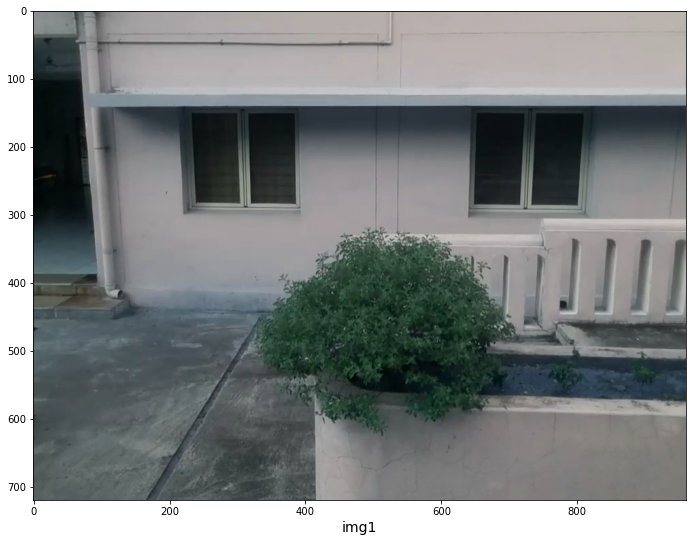

[209, 127, 411, 312]
mapped:209 1162 411 1303
[626, 127, 826, 310]
mapped:626 1162 826 1301


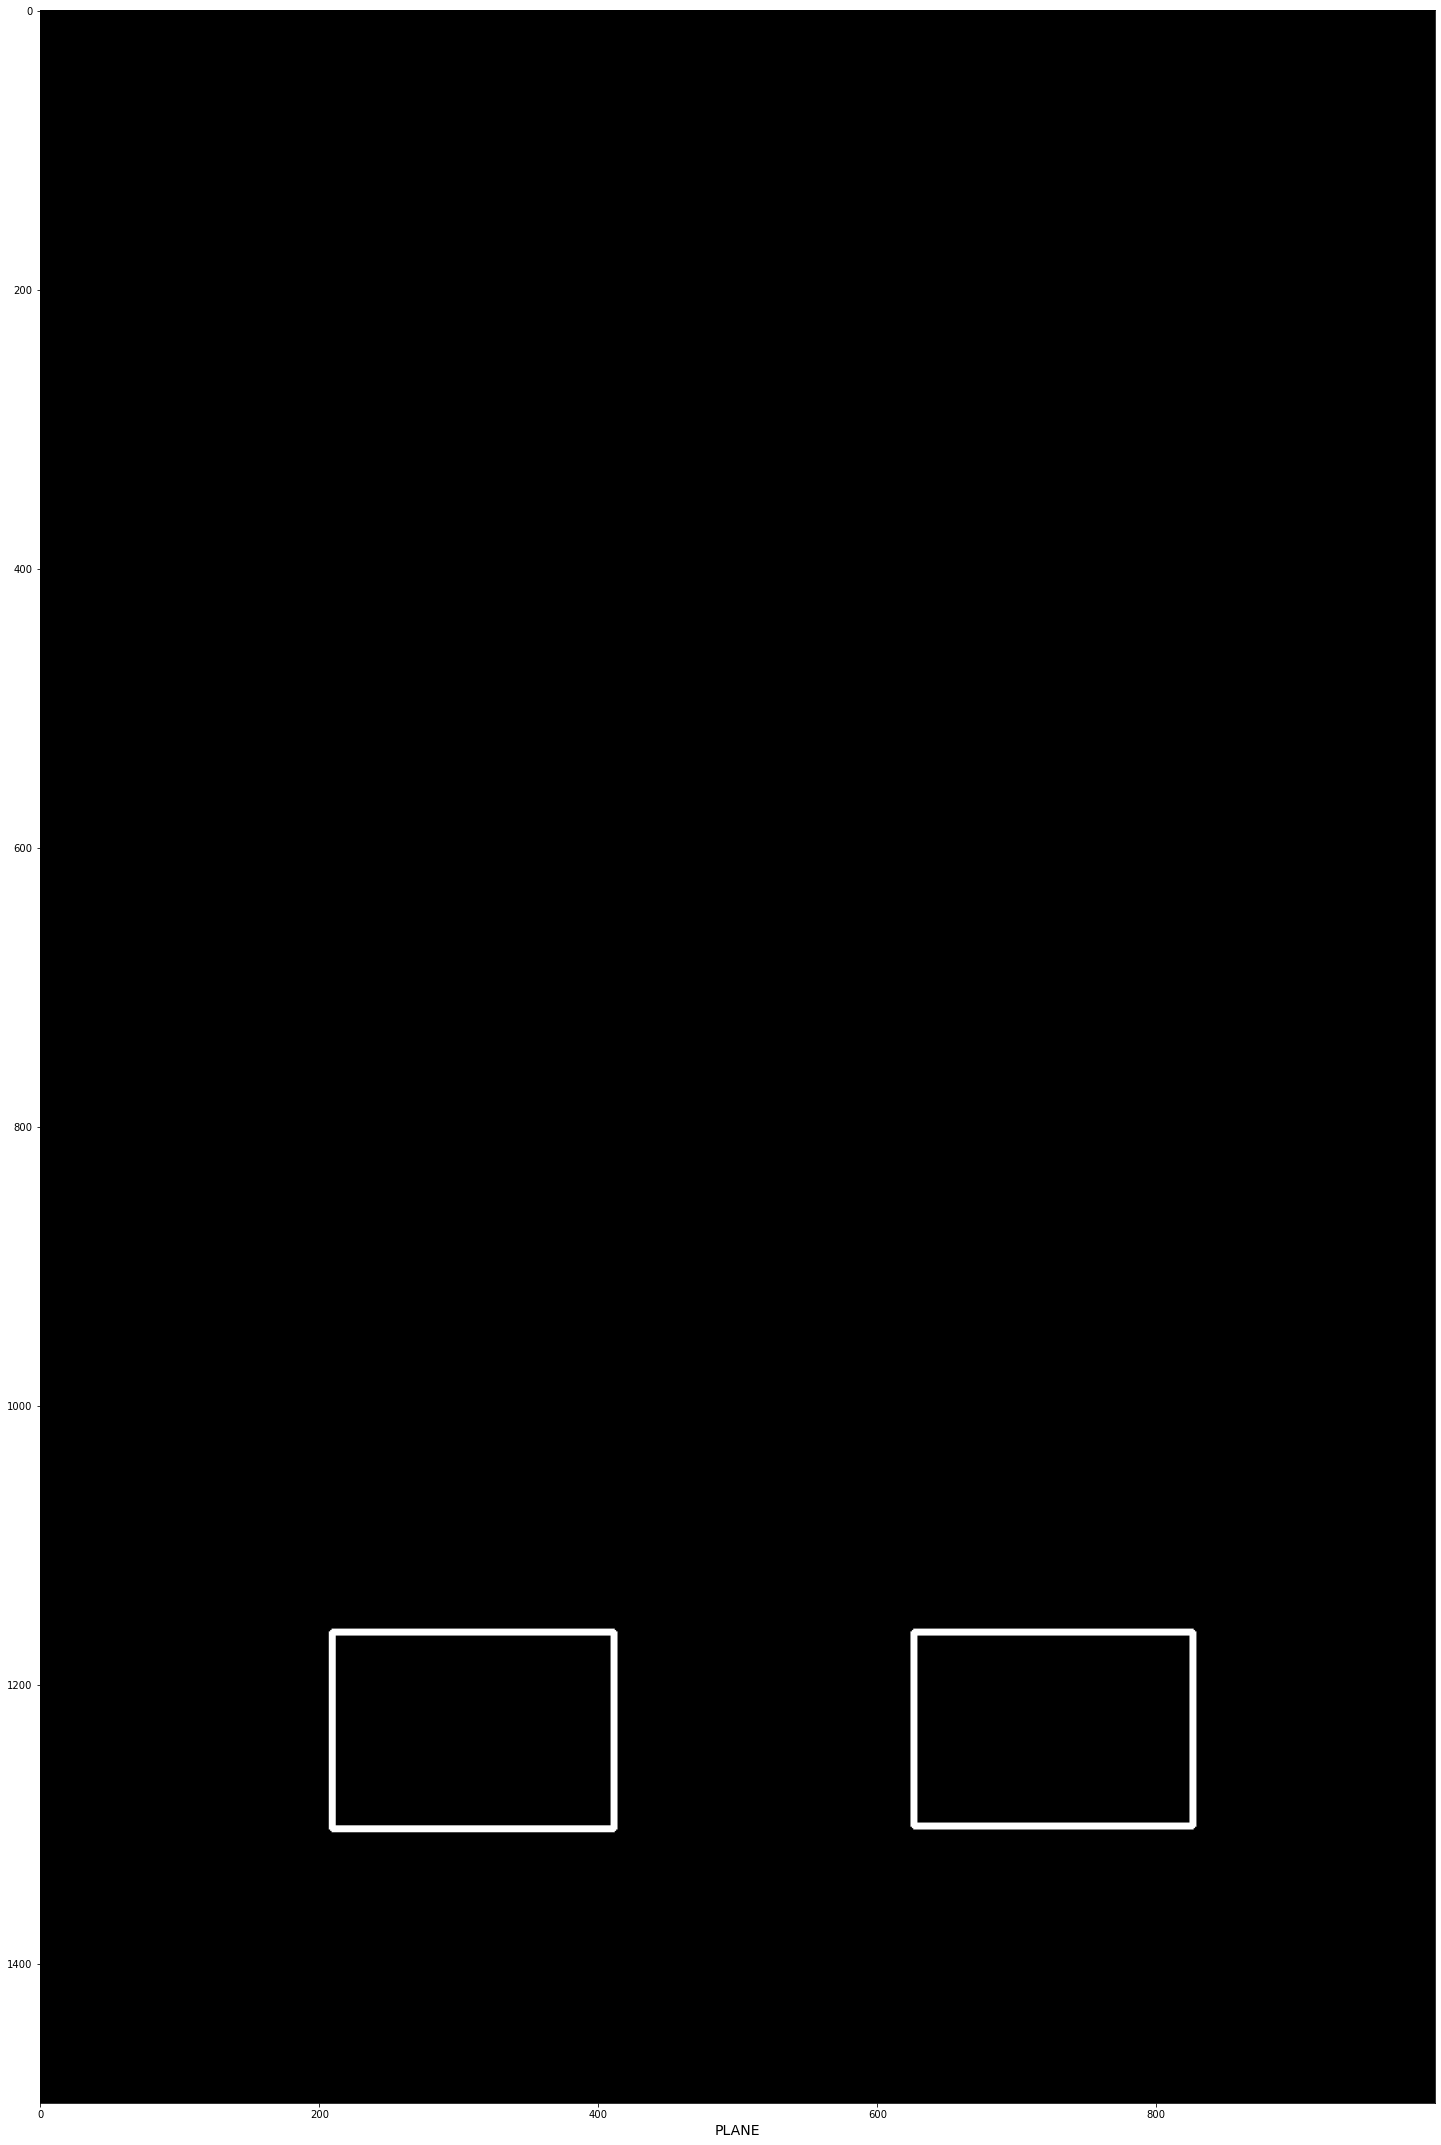

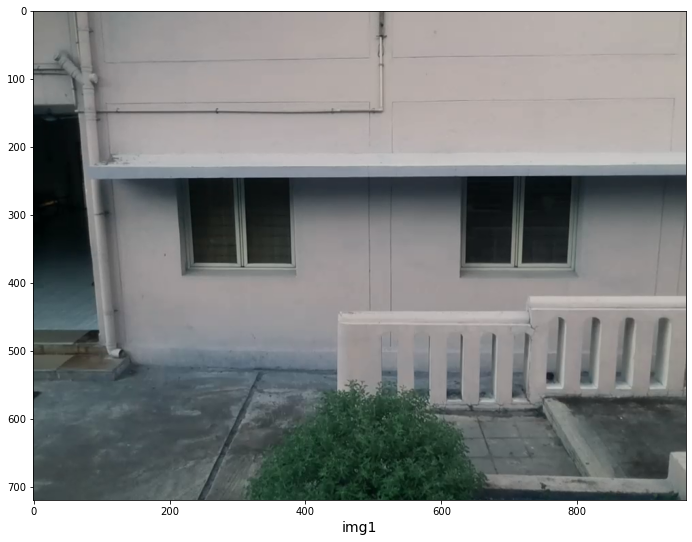

[612, 237, 805, 400]
mapped:612 1166 805 1290
[205, 235, 405, 397]
mapped:205 1164 405 1288


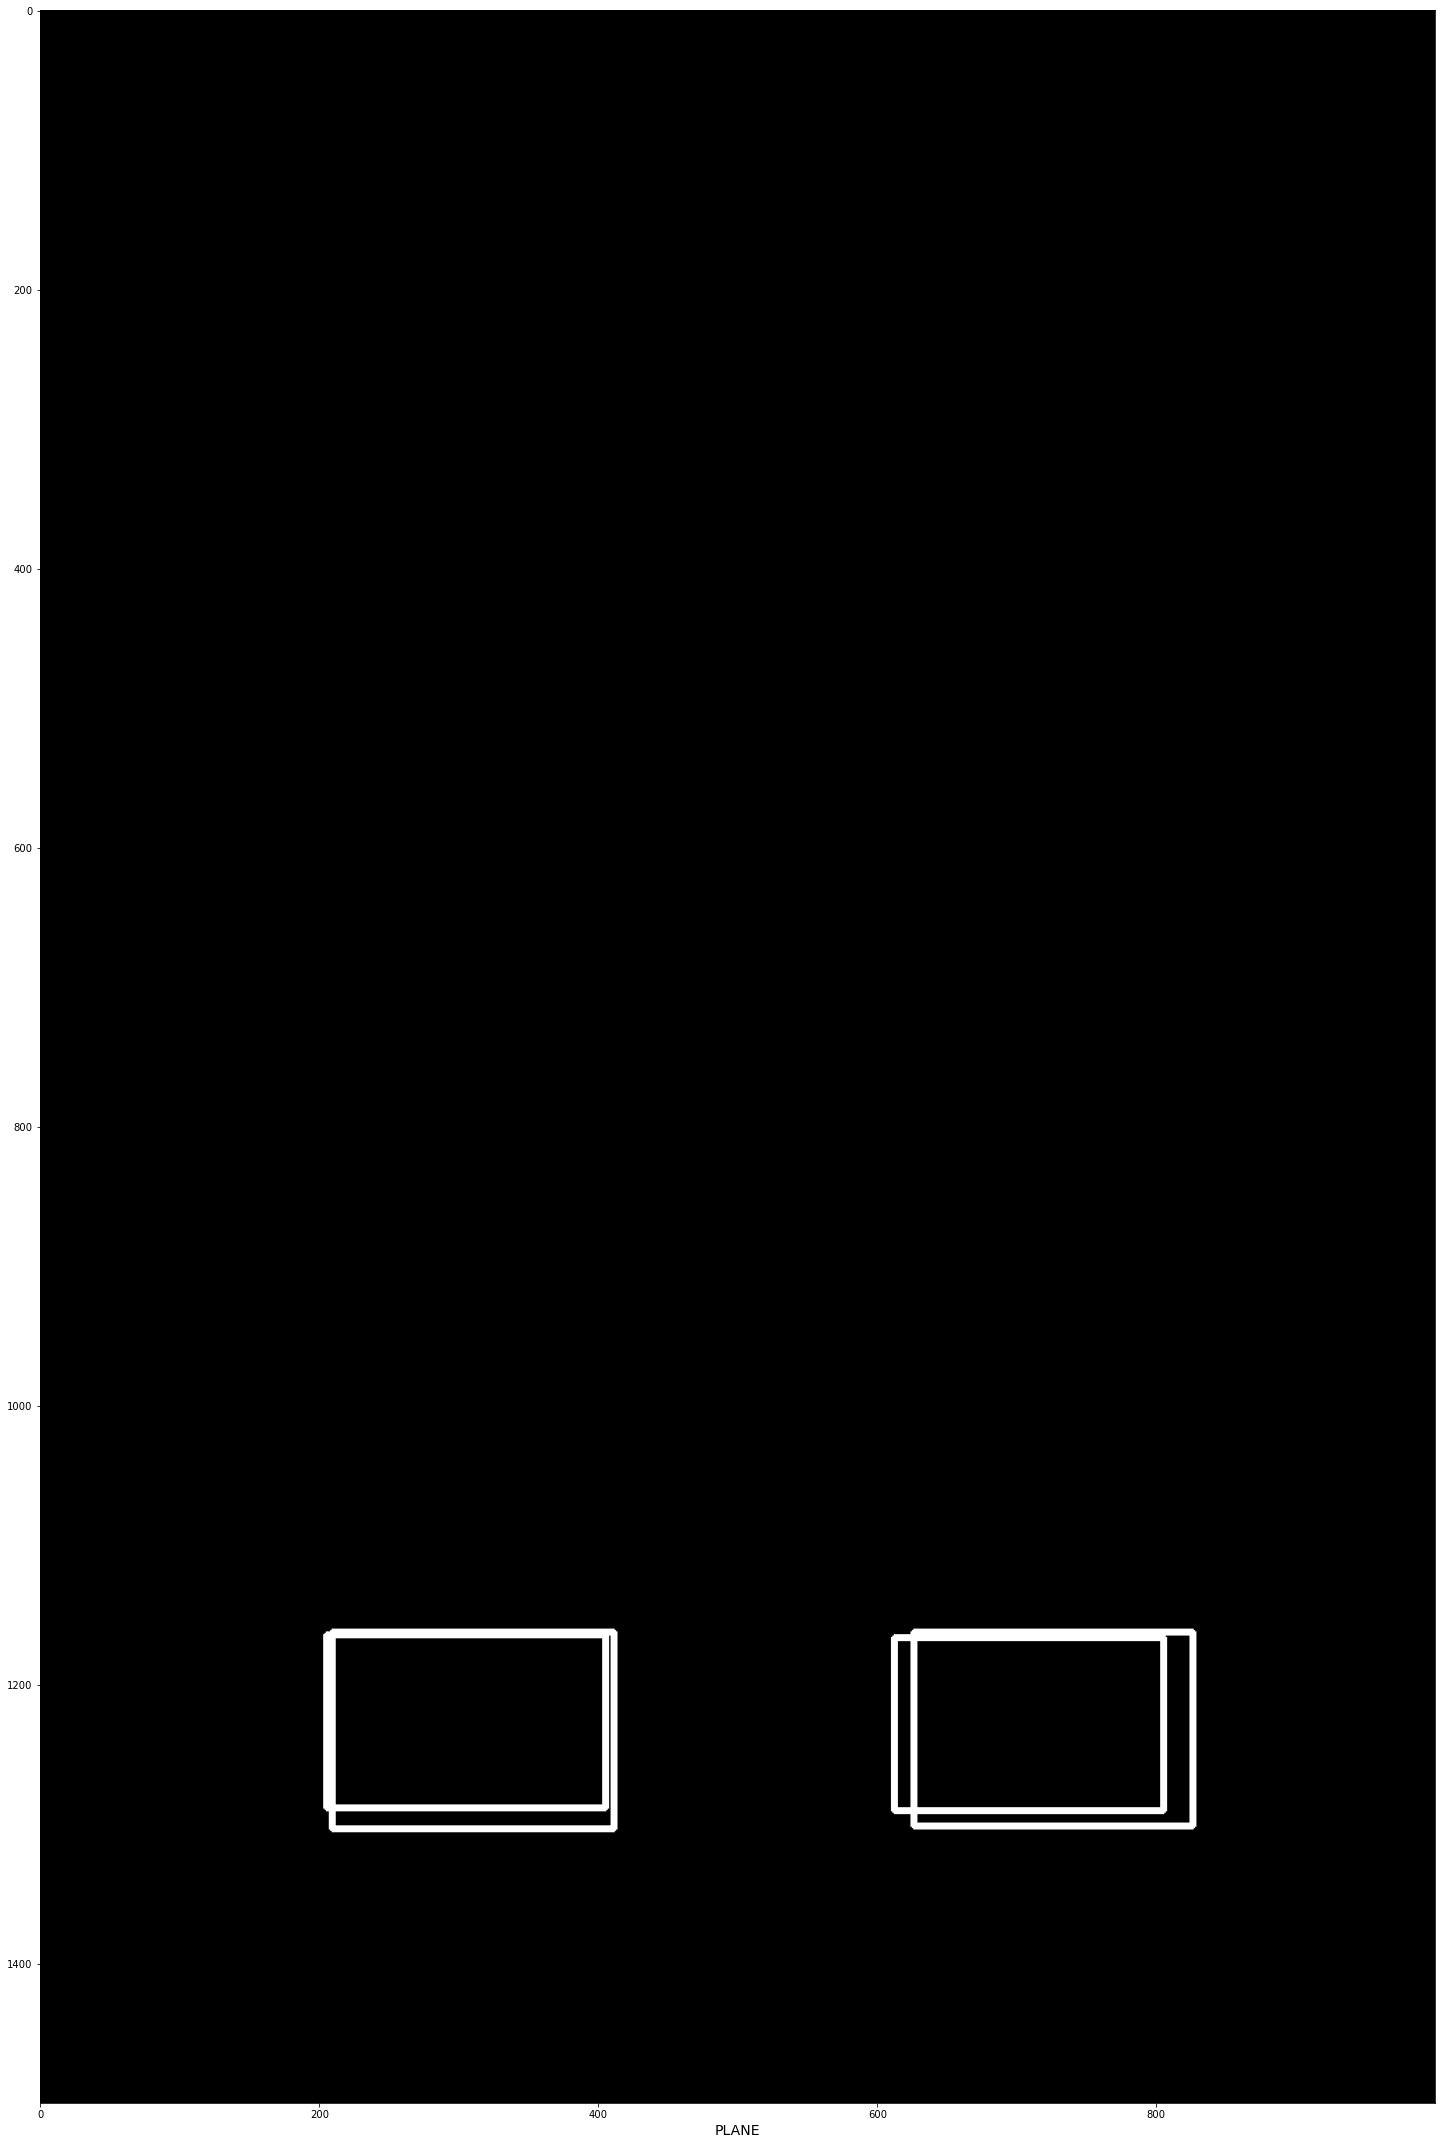

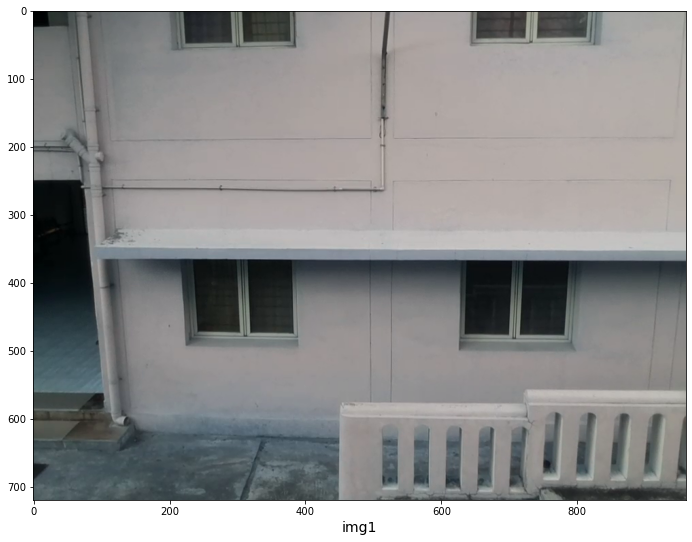

[213, 360, 408, 507]
mapped:213 1170 408 1281
[612, 357, 802, 502]
mapped:612 1167 802 1278


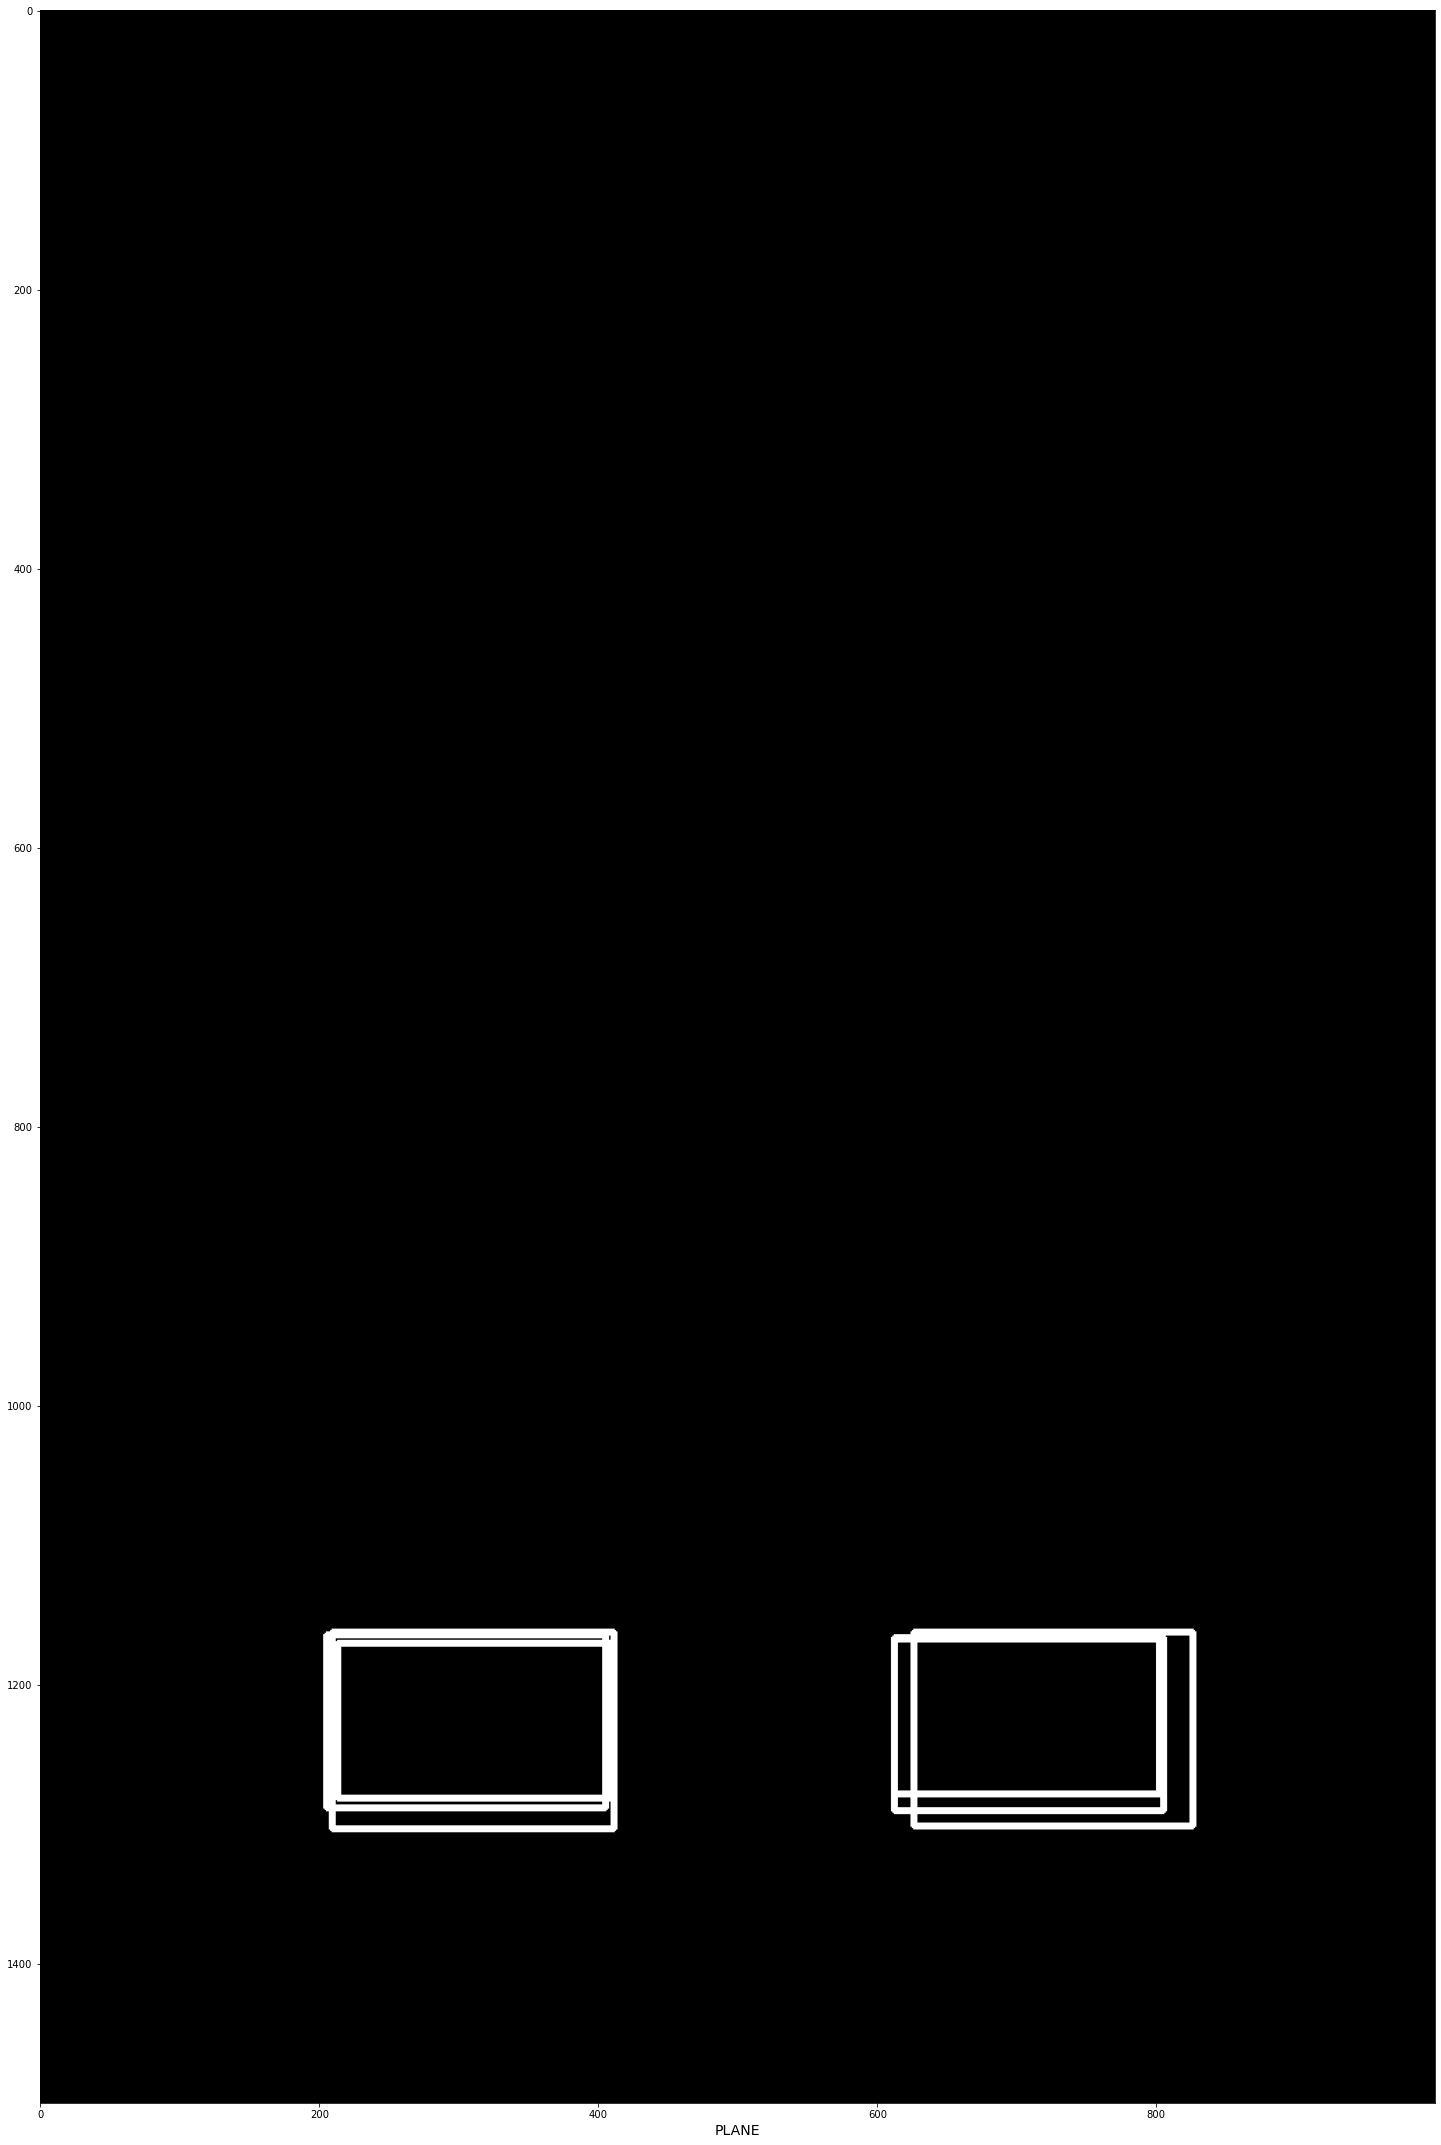

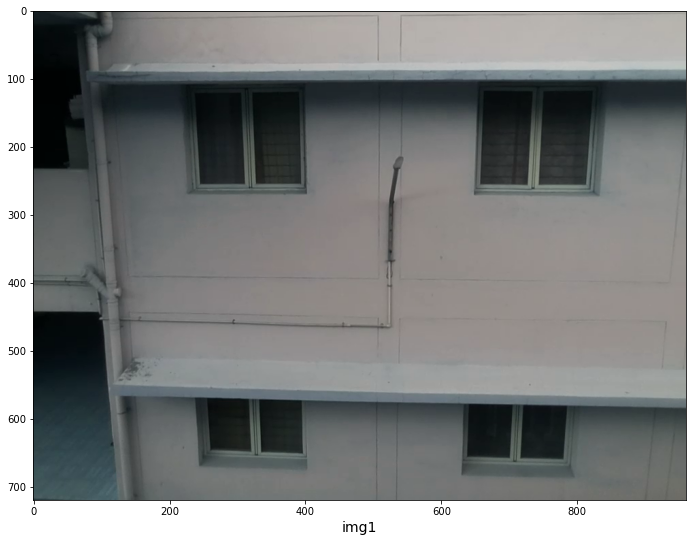

[632, 585, 787, 675]
mapped:632 1171 787 1239
[242, 577, 397, 665]
mapped:242 1165 397 1232
[211, 97, 421, 285]
mapped:211 799 421 942
[636, 97, 841, 282]
mapped:636 799 841 940


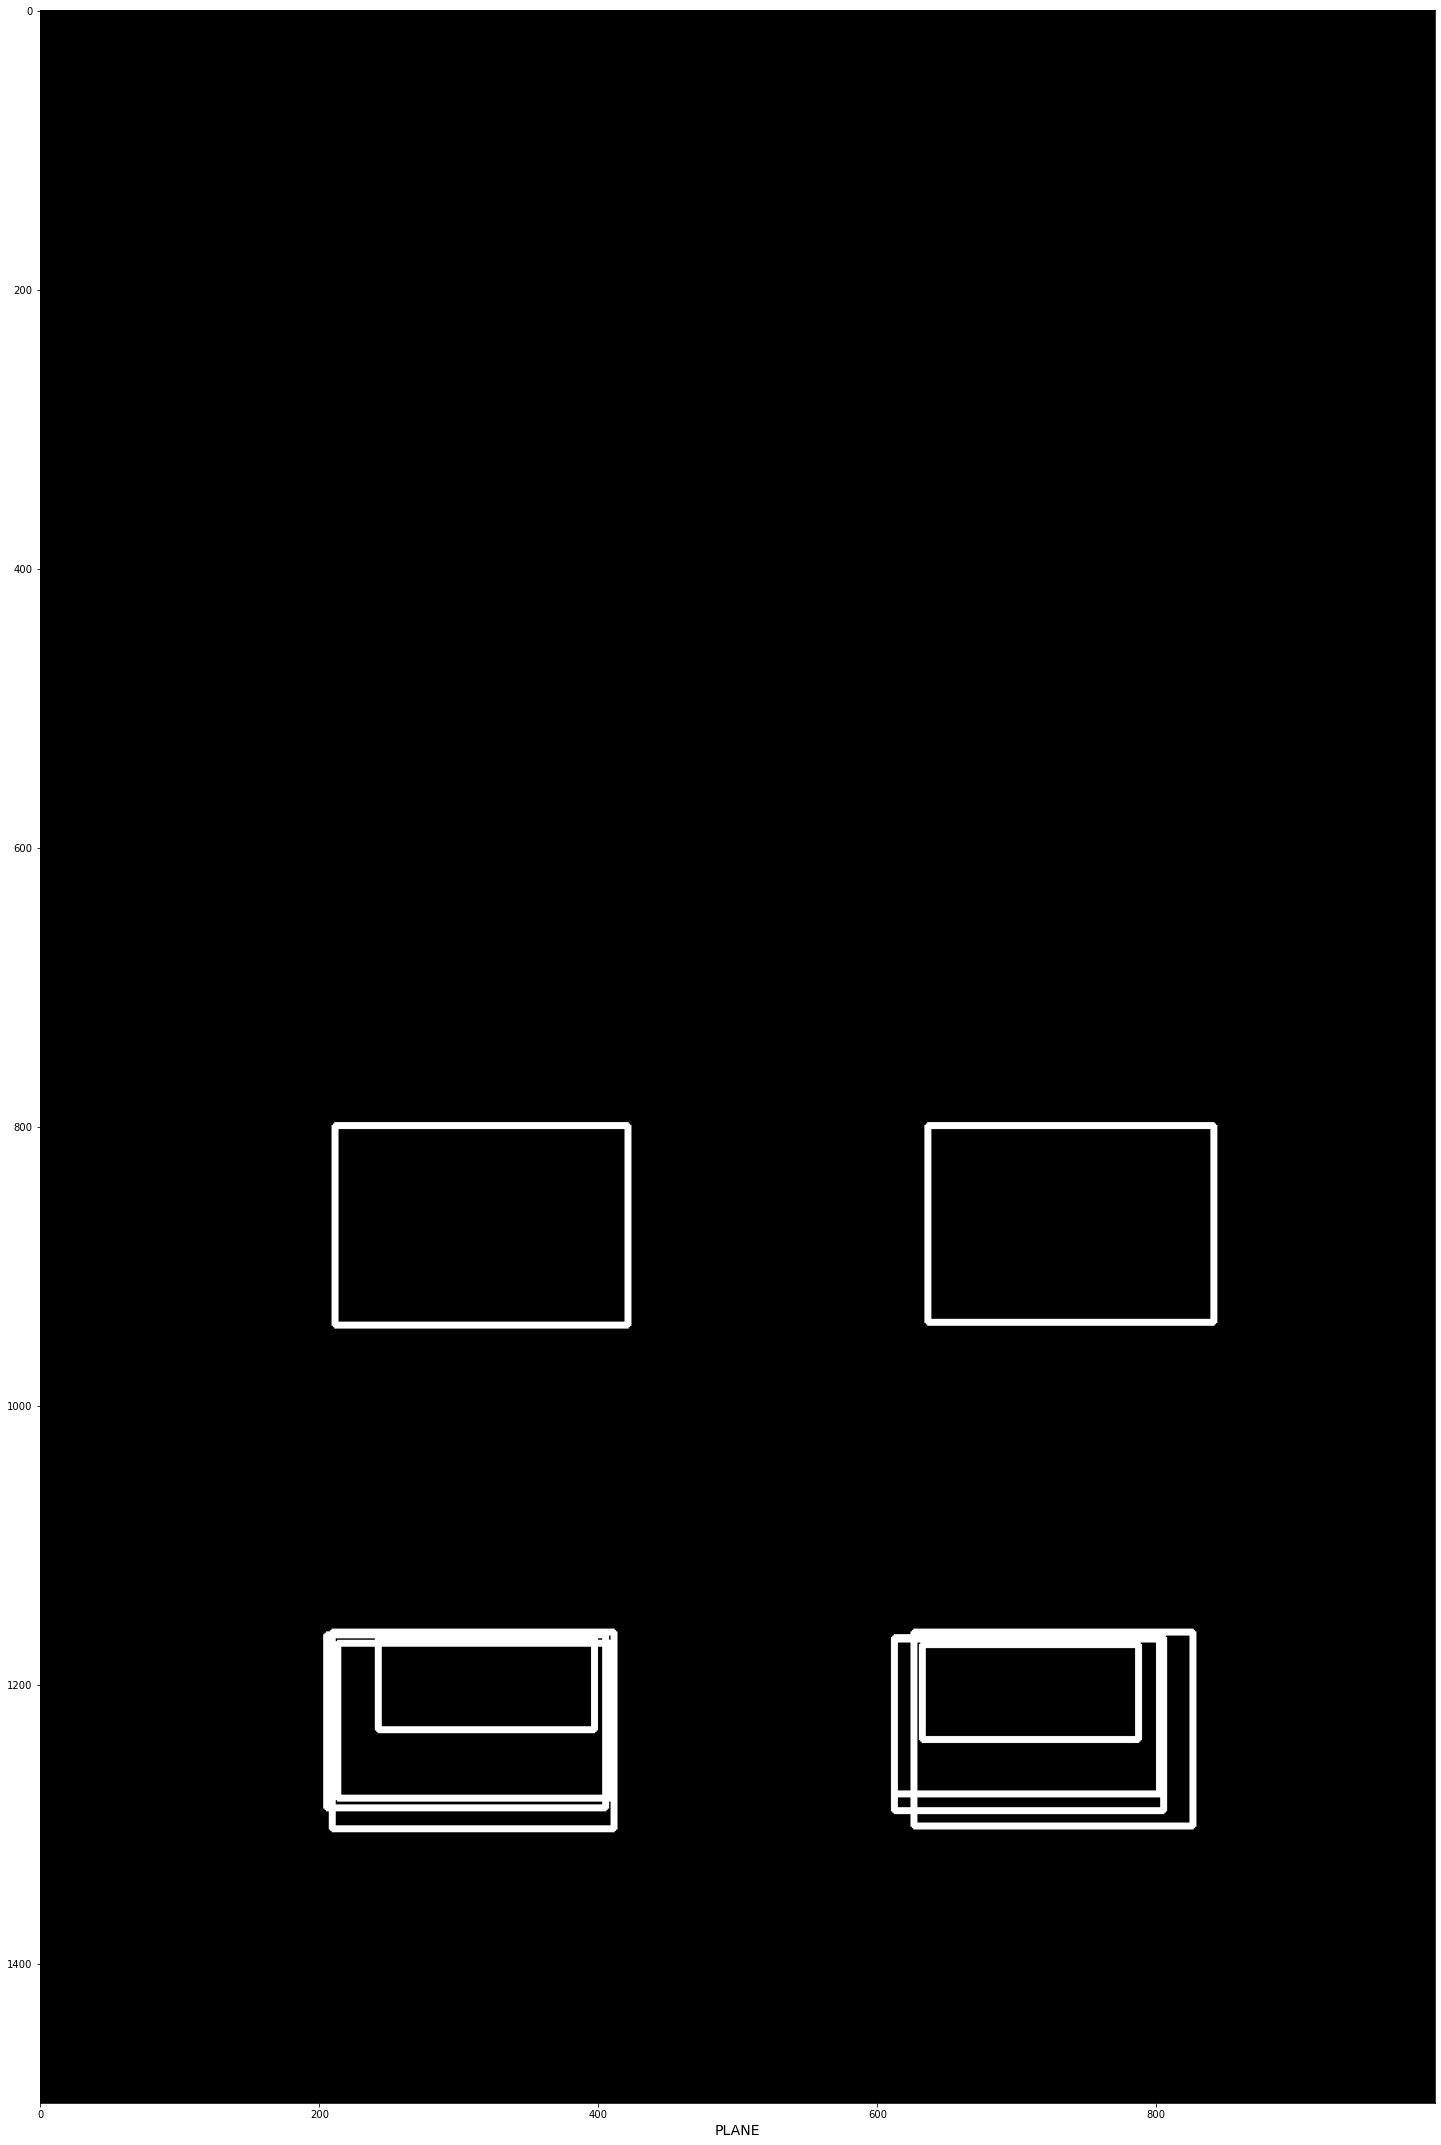

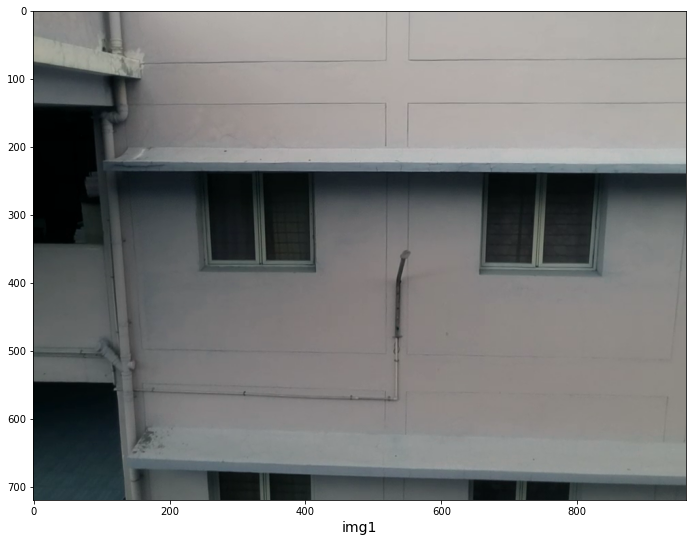

[233, 227, 438, 400]
mapped:233 831 438 962
[642, 230, 839, 392]
mapped:642 833 839 956


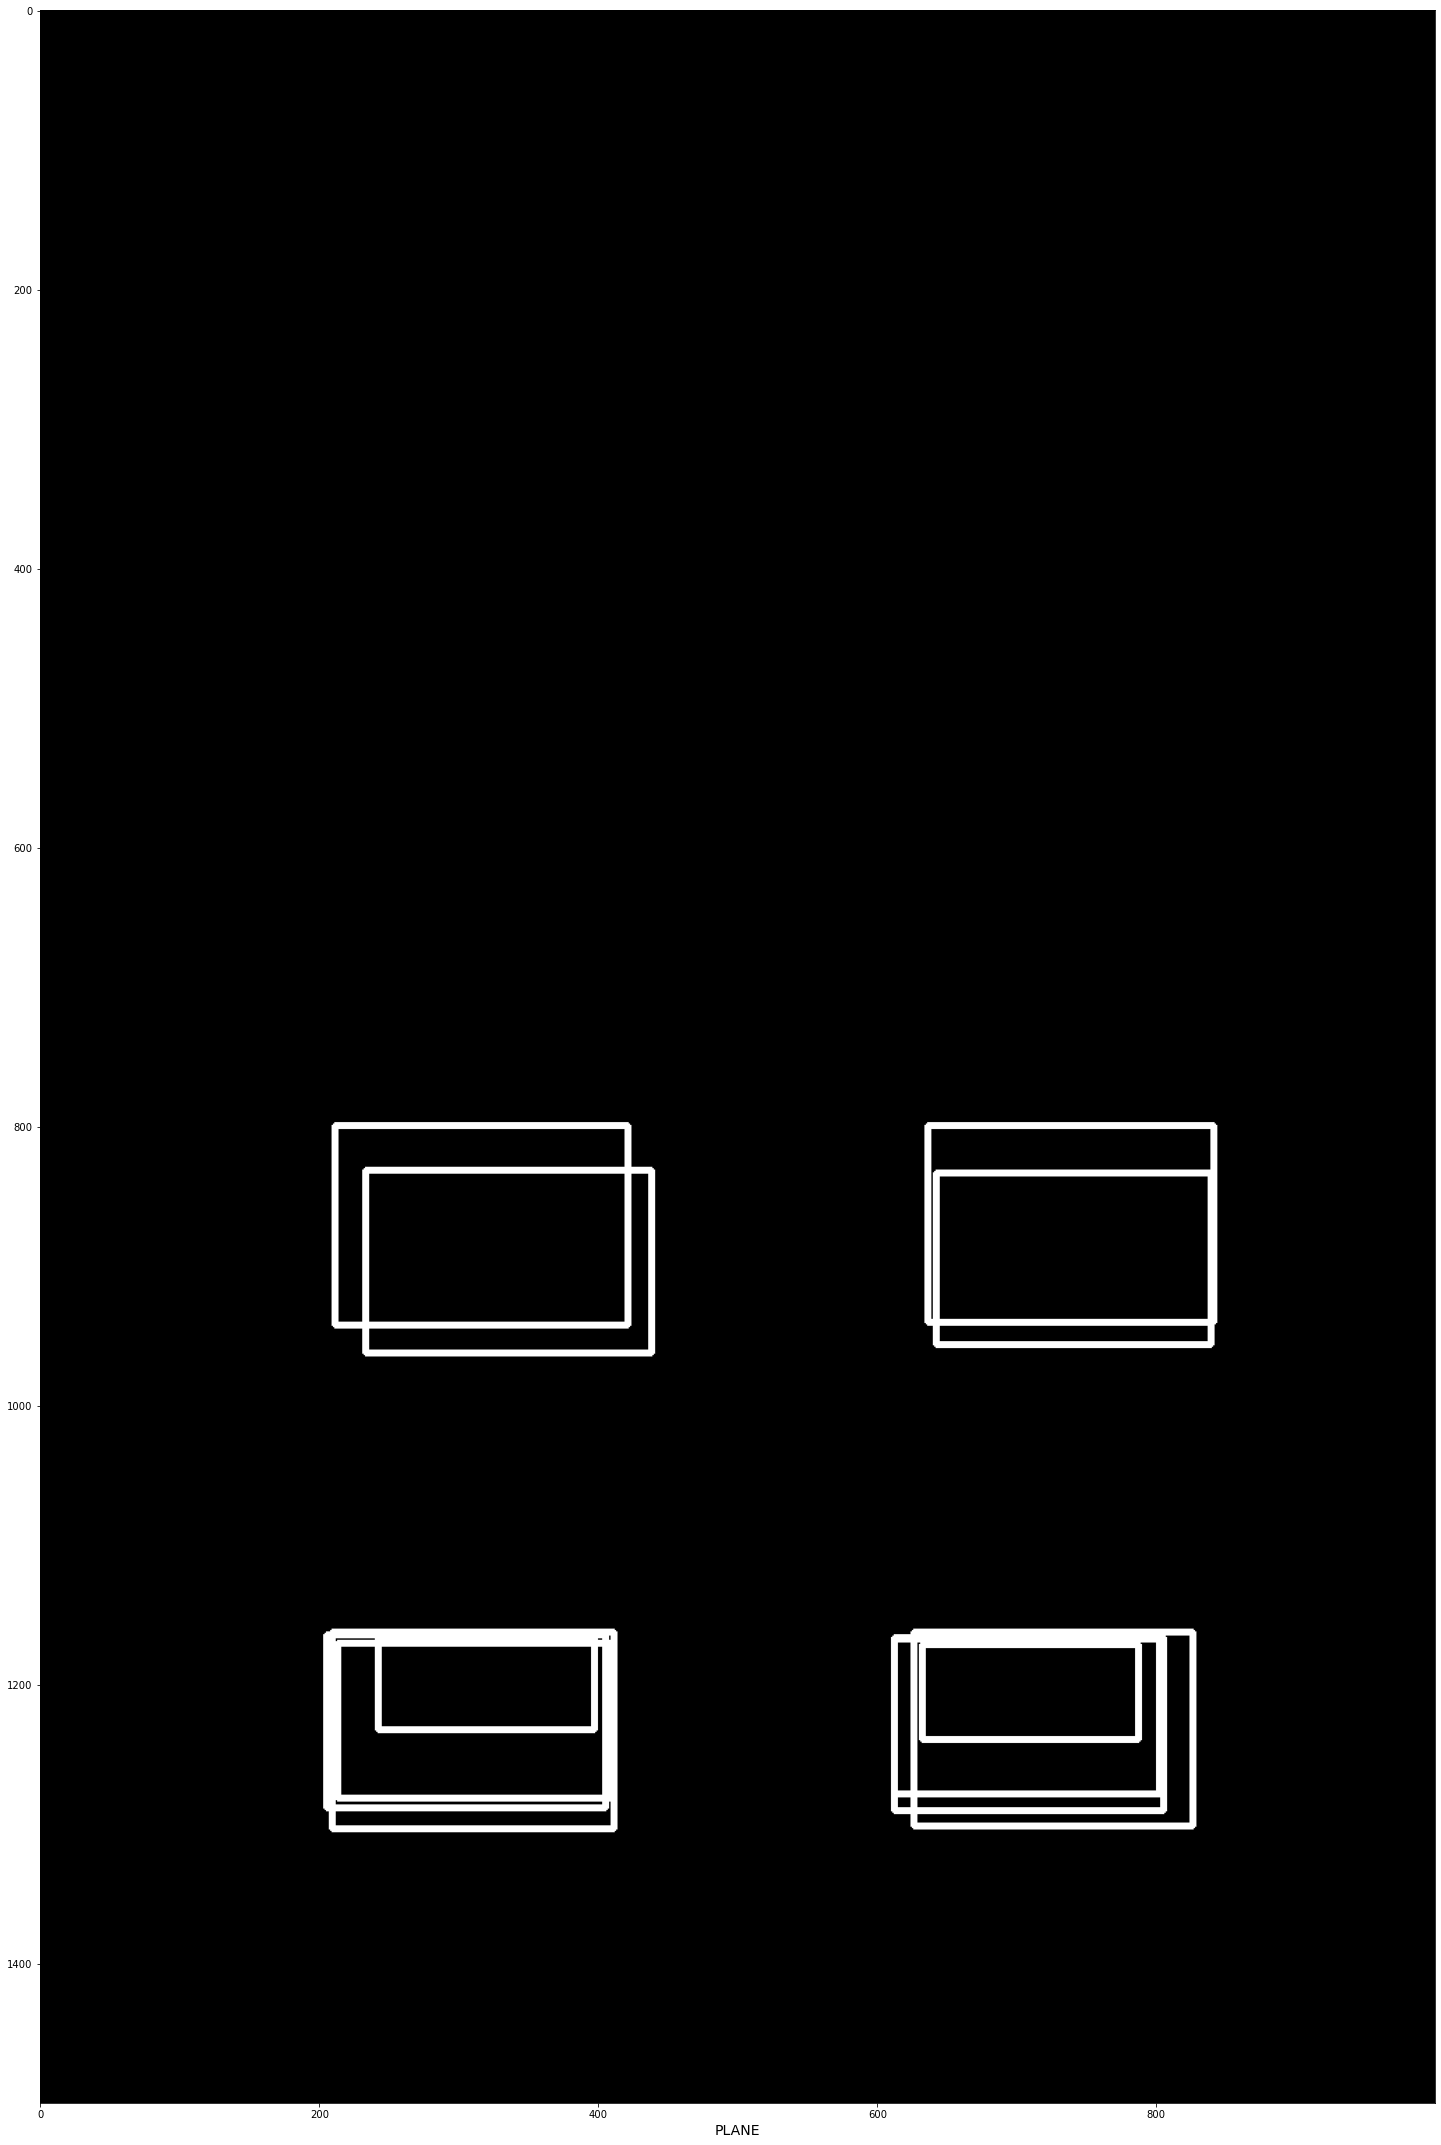

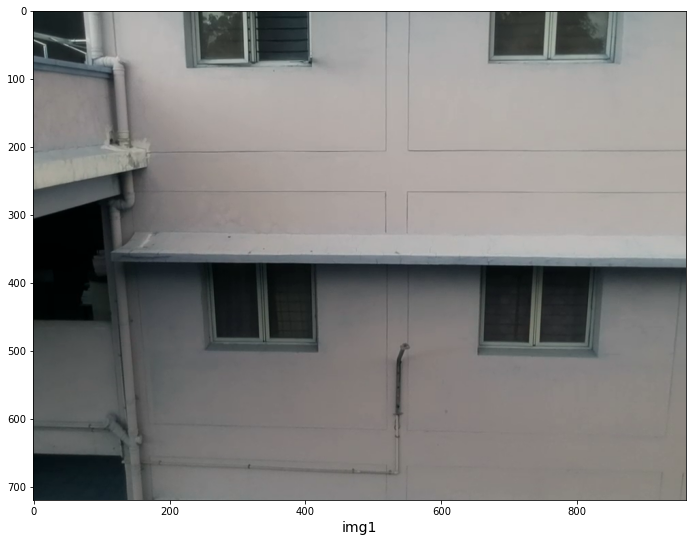

[241, 367, 444, 517]
mapped:241 857 444 971
[662, 382, 825, 502]
mapped:662 868 825 960
[651, 0, 873, 97]
mapped:651 578 873 652
[225, 0, 417, 82]
mapped:225 578 417 640


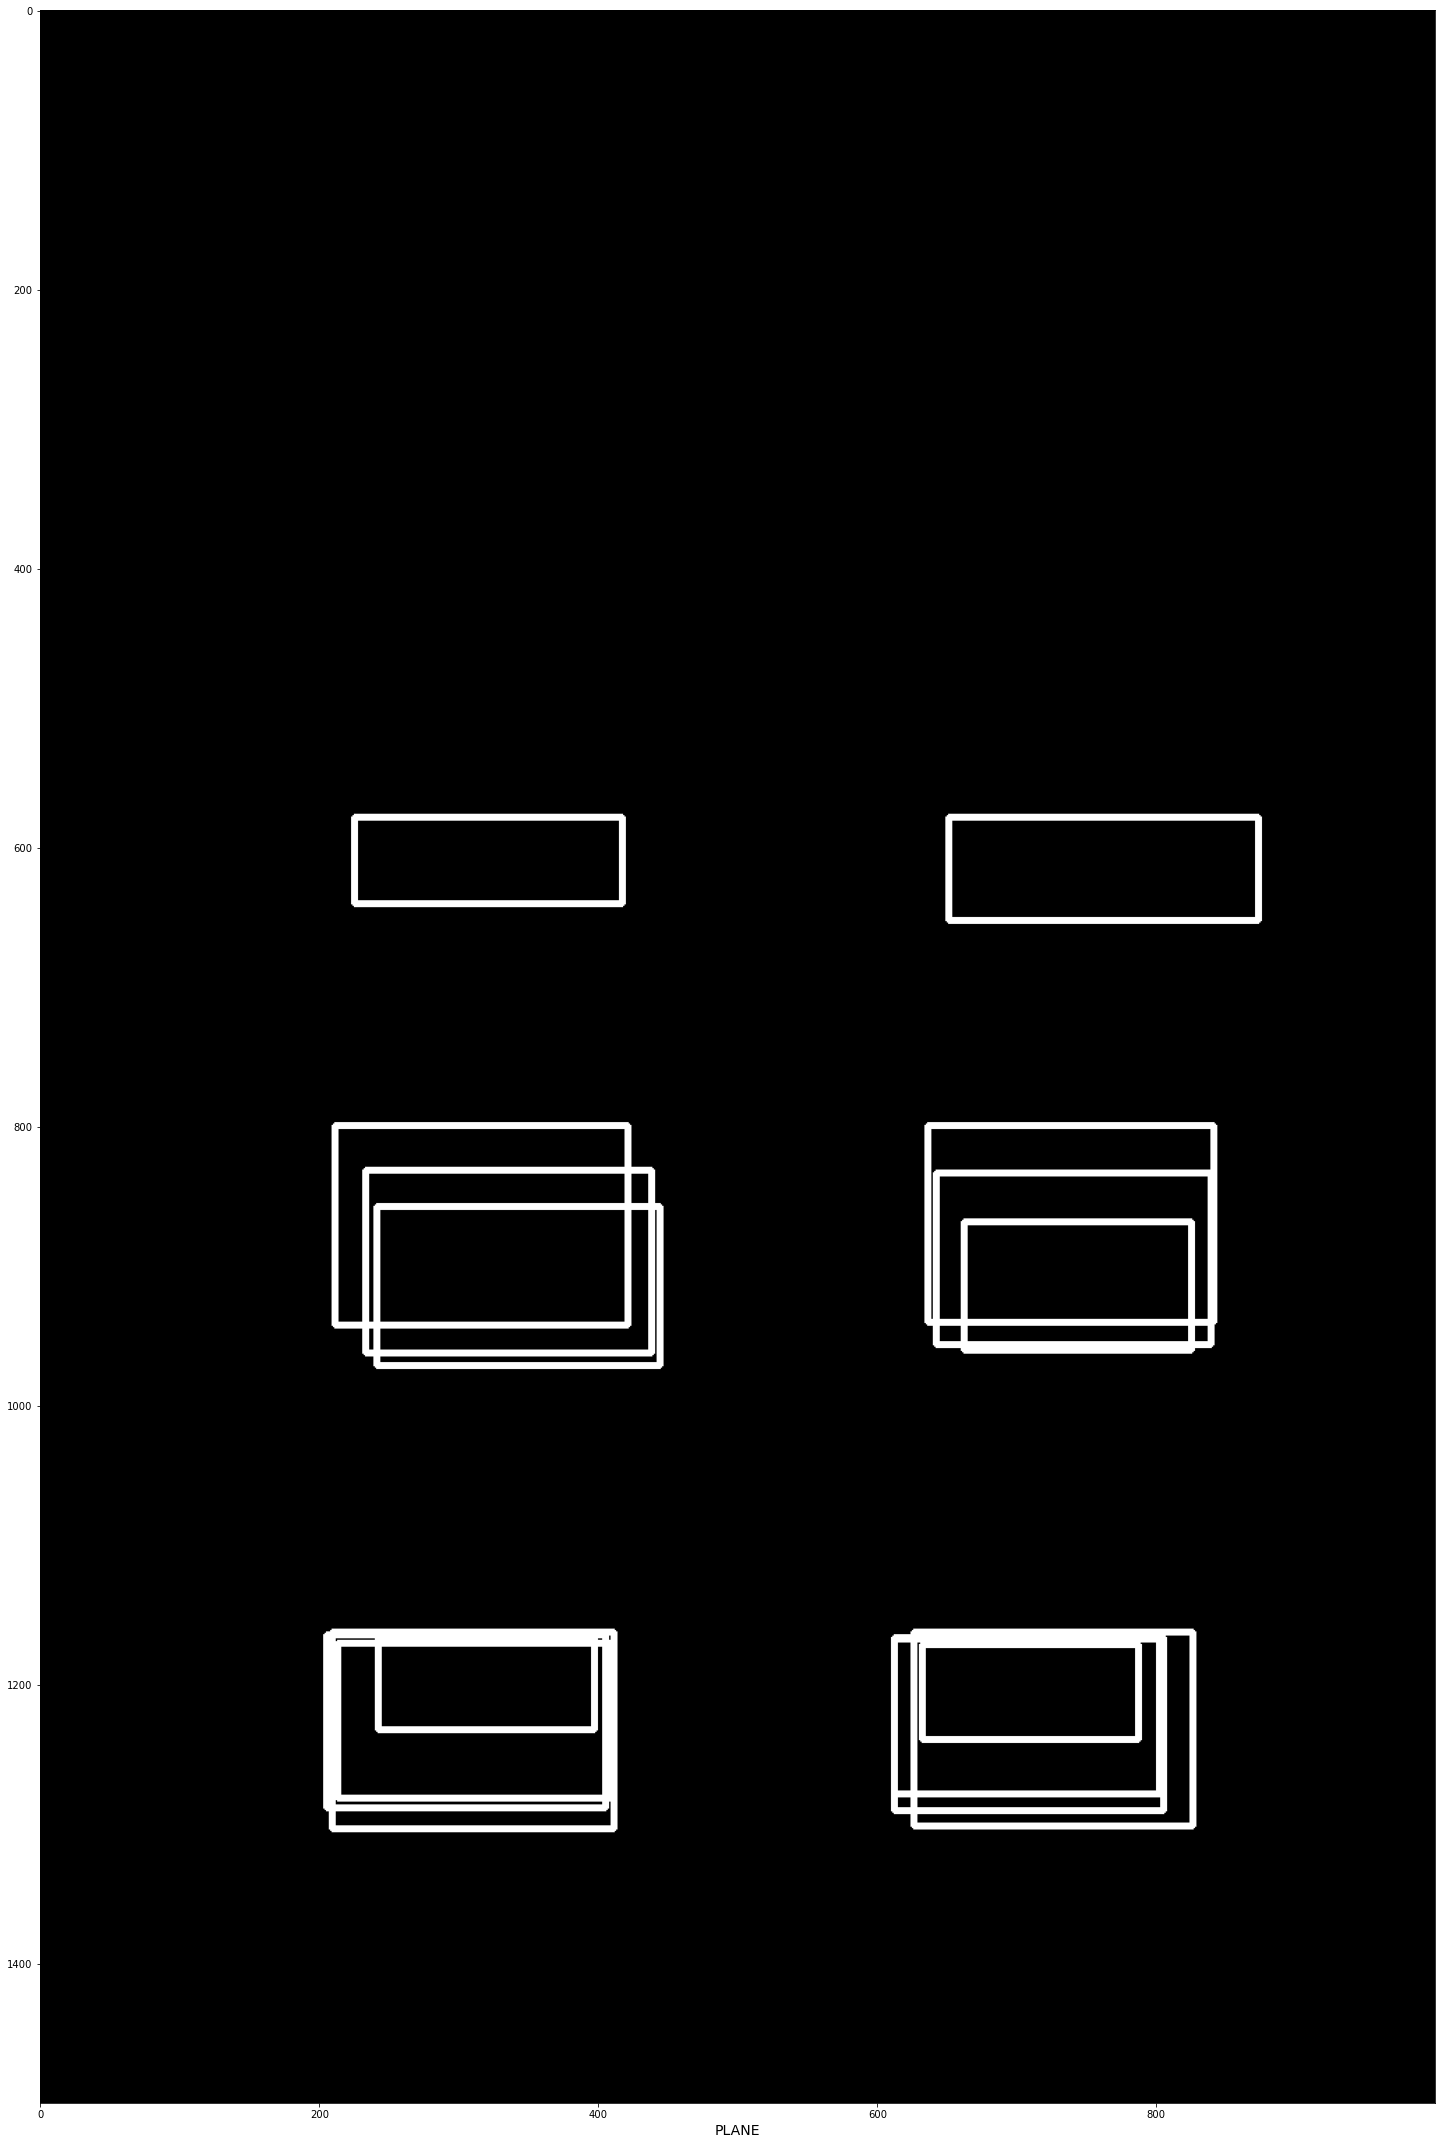

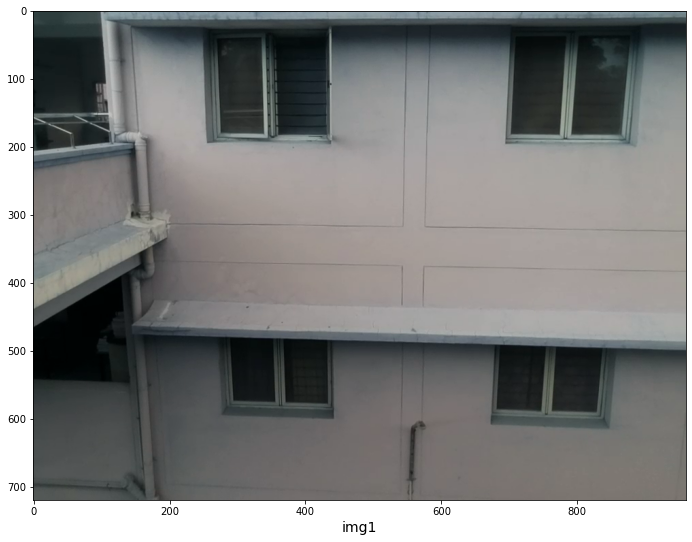

[682, 497, 845, 605]
mapped:682 874 845 956
[280, 485, 440, 595]
mapped:280 865 440 948
[676, 12, 899, 207]
mapped:676 505 899 653
[252, 35, 445, 192]
mapped:252 522 445 642


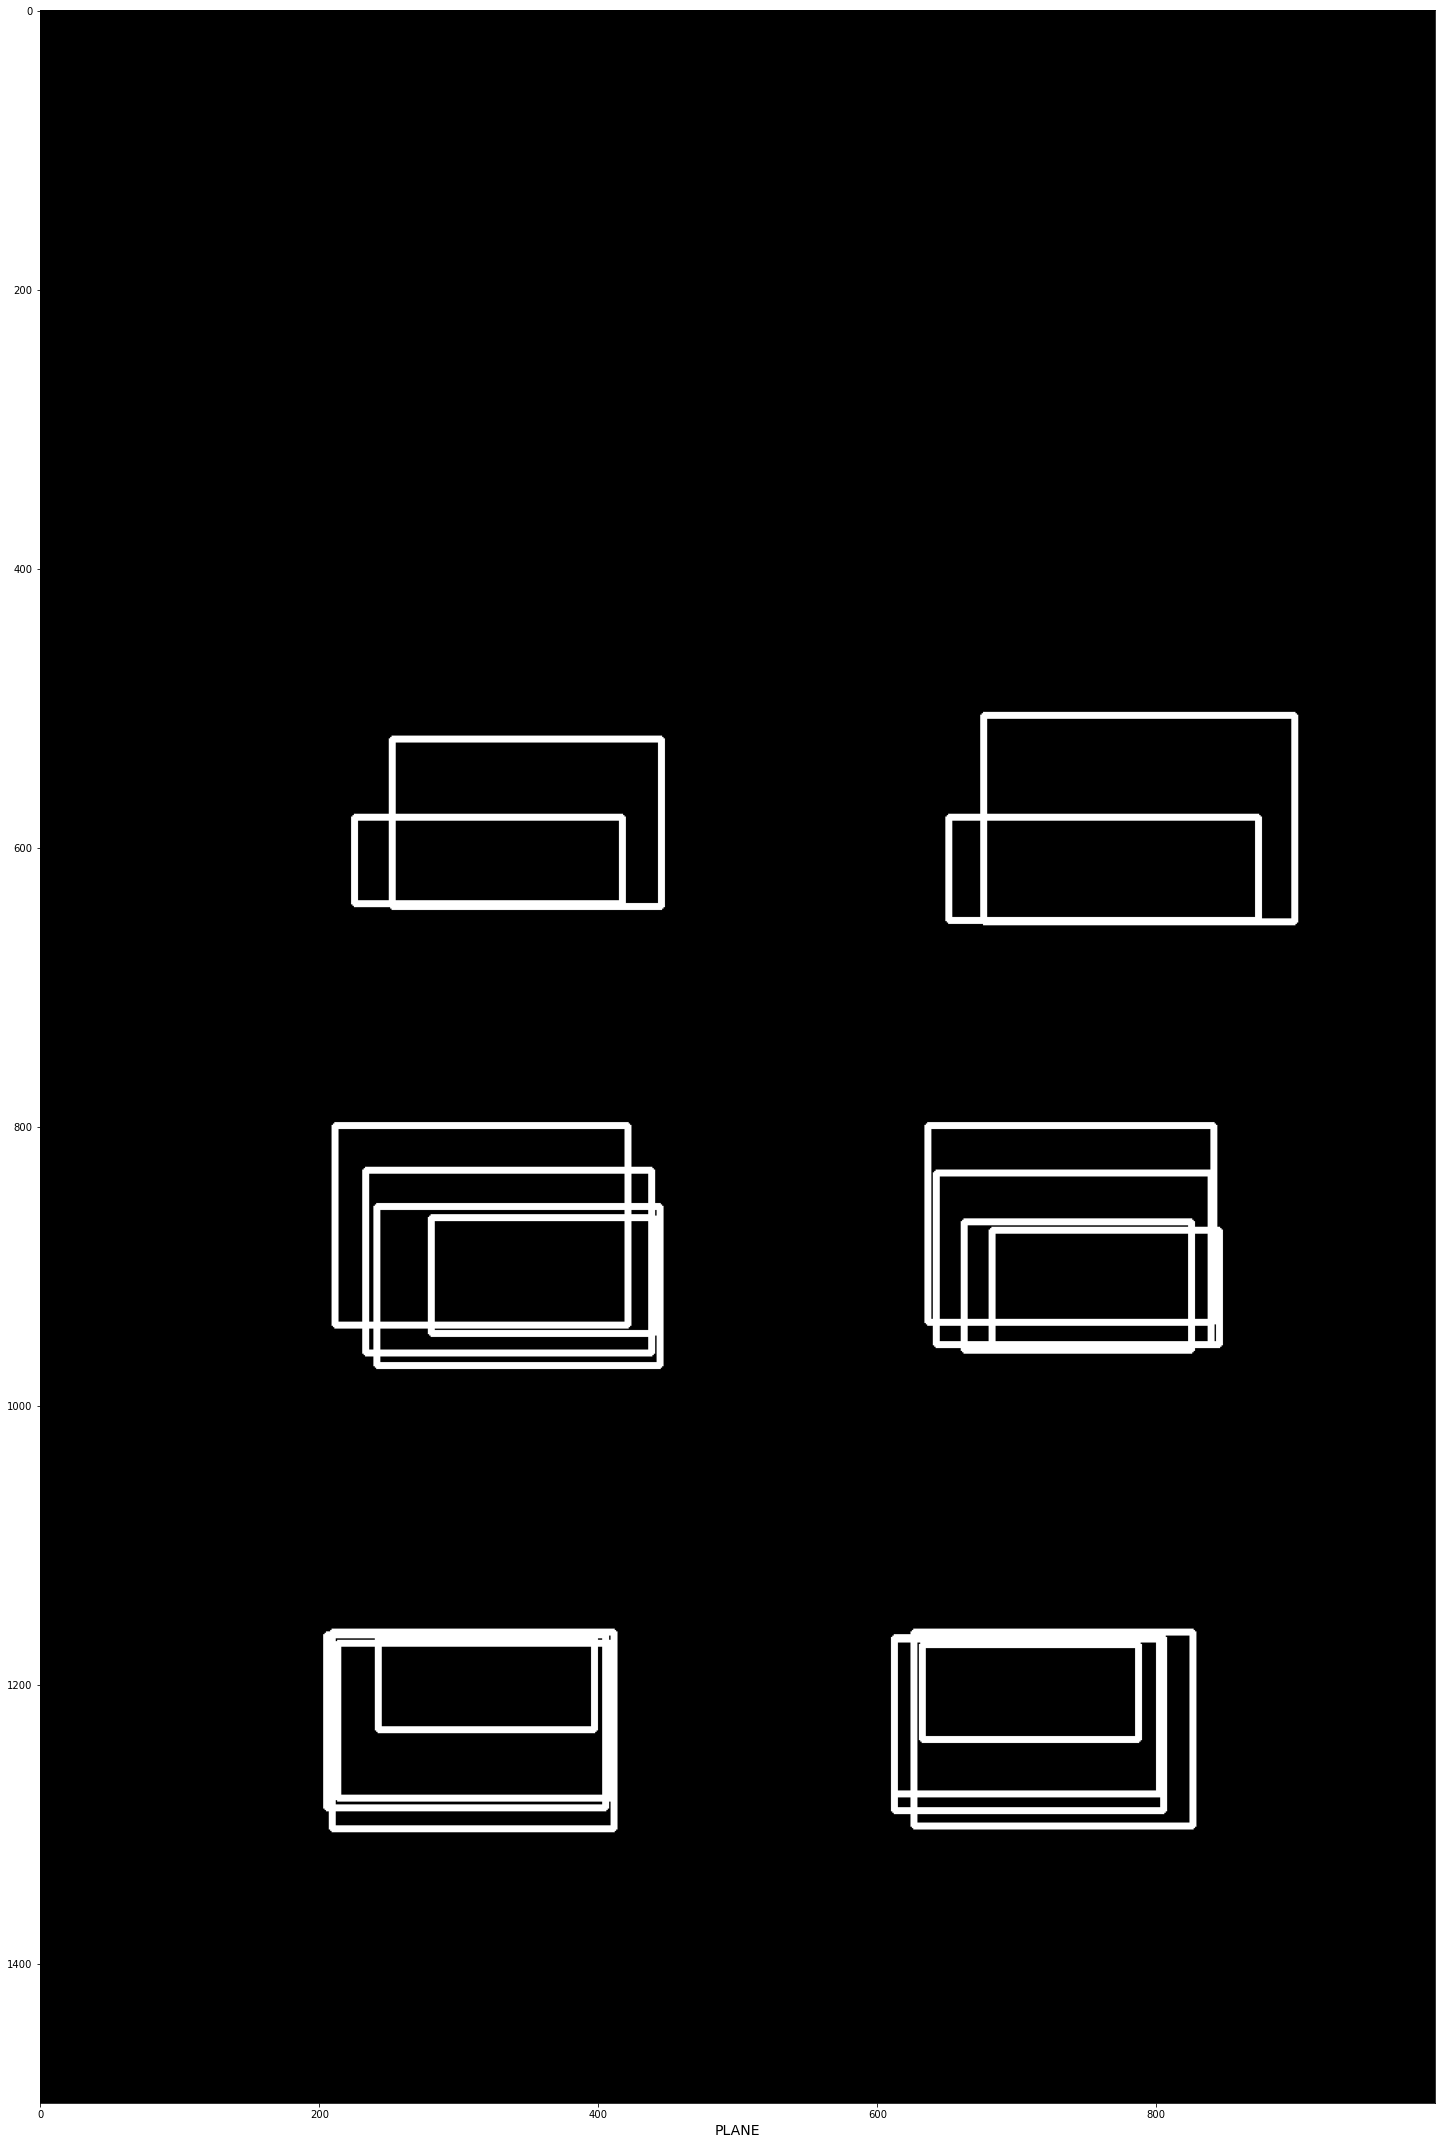

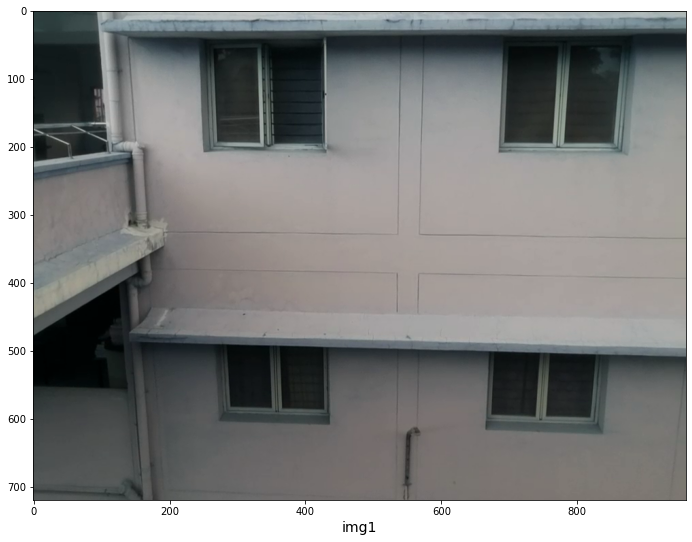

[672, 507, 832, 617]
mapped:672 871 832 955
[277, 497, 435, 605]
mapped:277 864 435 946
[238, 25, 461, 222]
mapped:238 505 461 655
[663, 22, 880, 220]
mapped:663 502 880 653


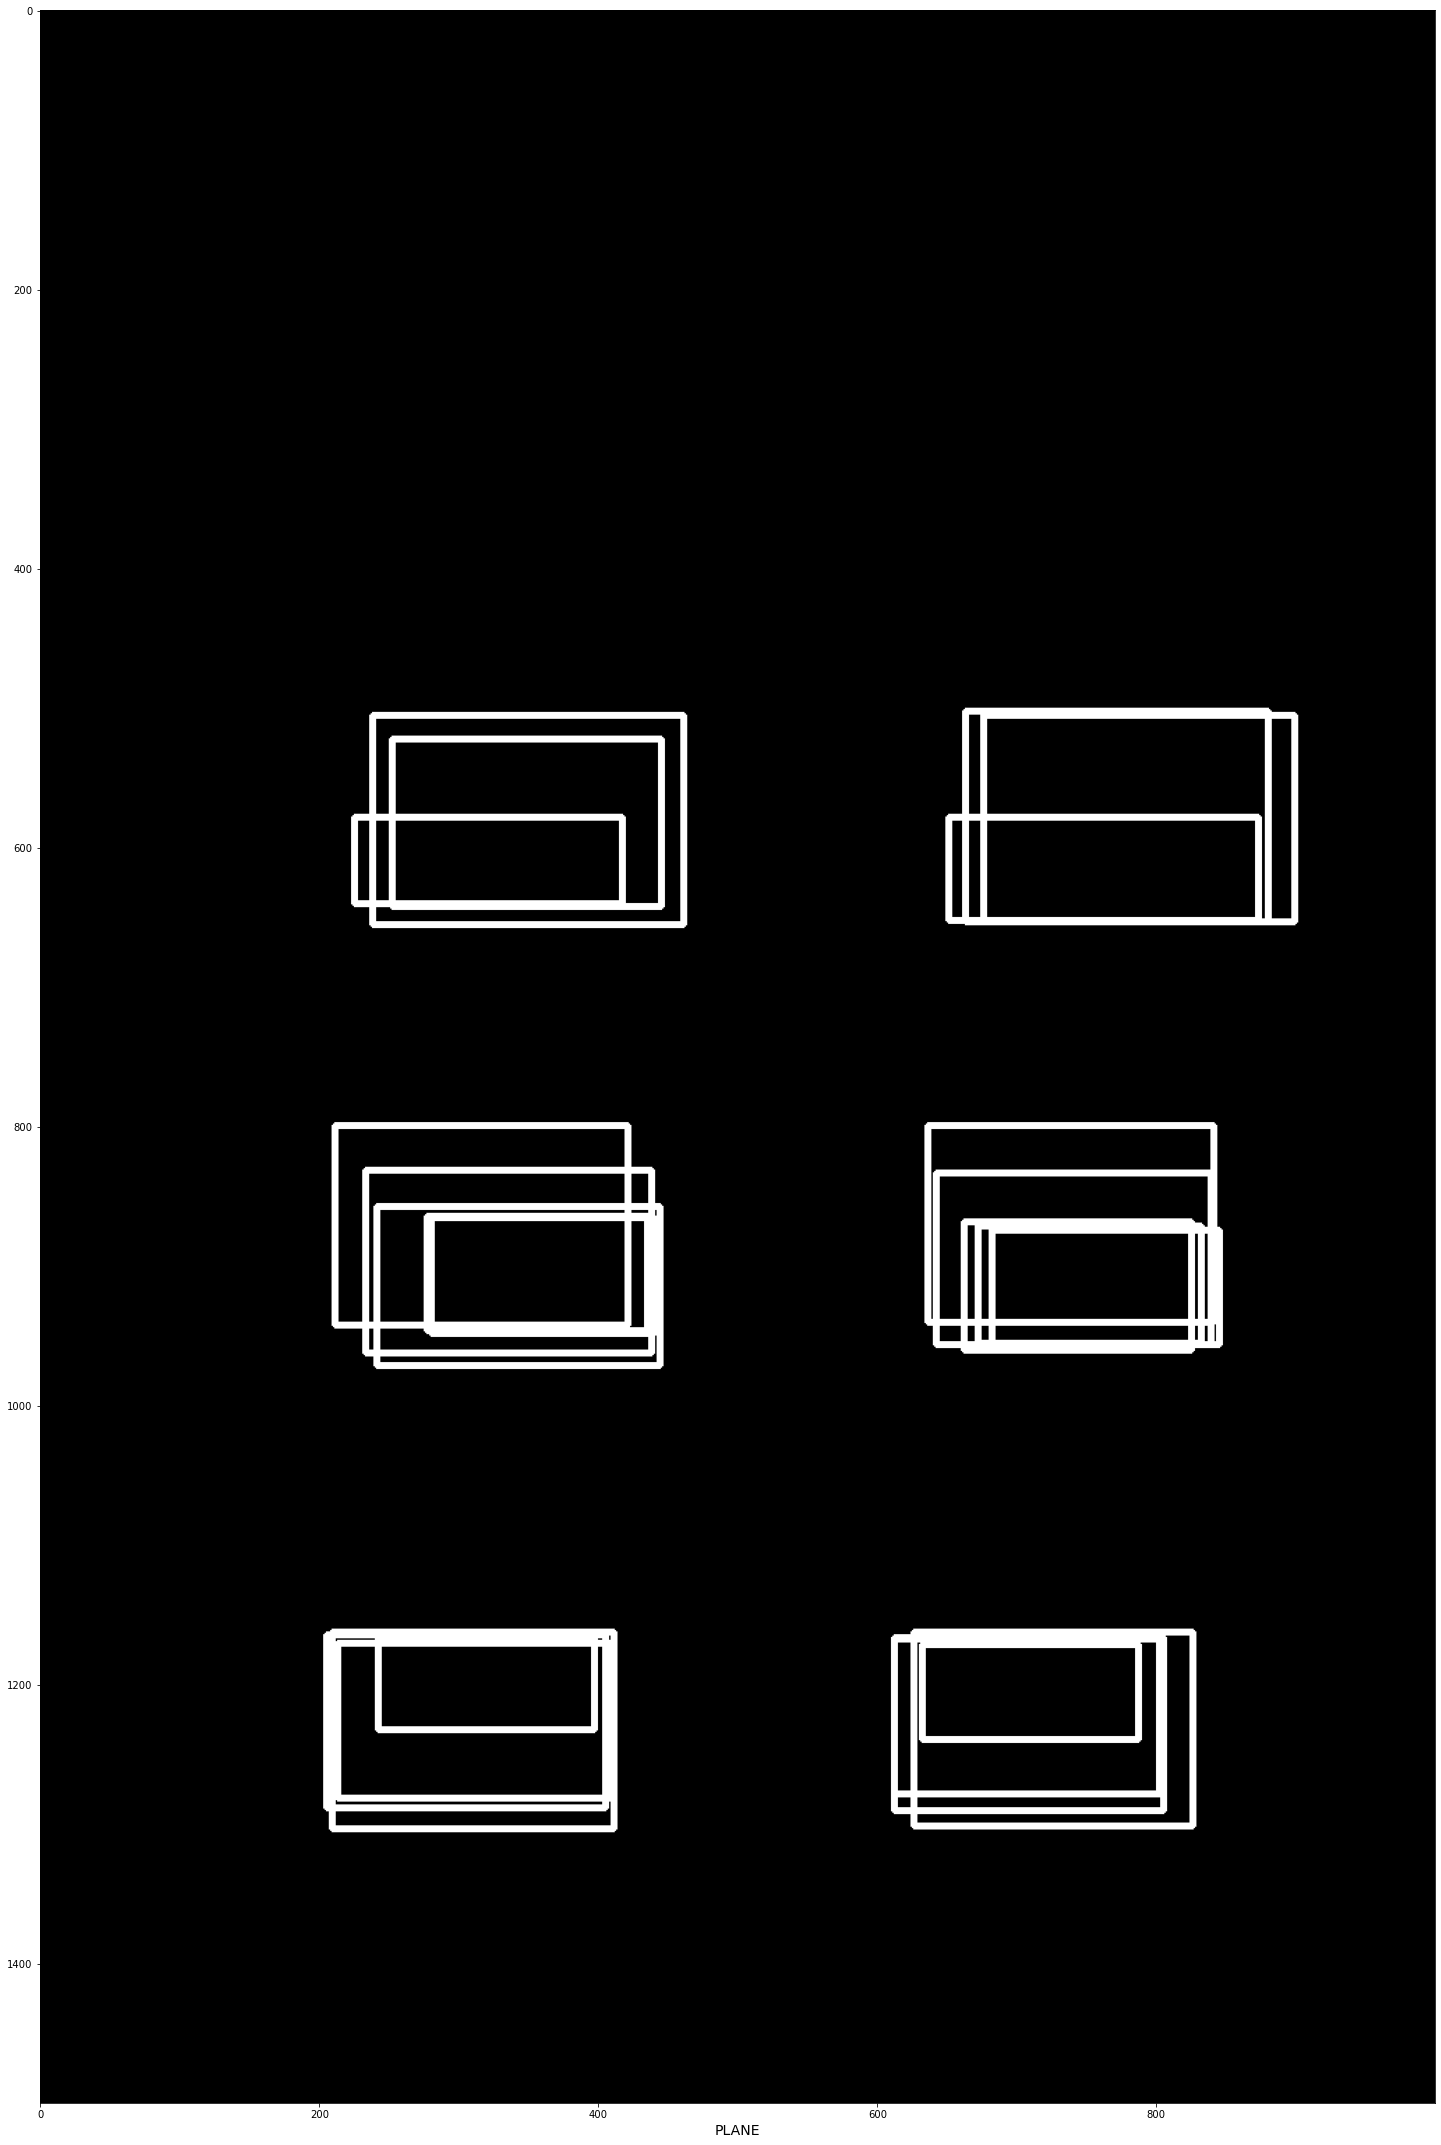

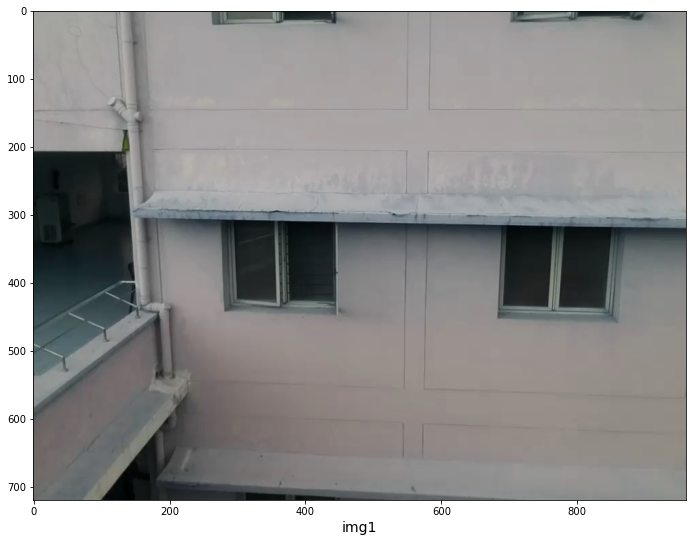

[264, 305, 466, 465]
mapped:264 560 466 682
[671, 297, 868, 455]
mapped:671 554 868 674


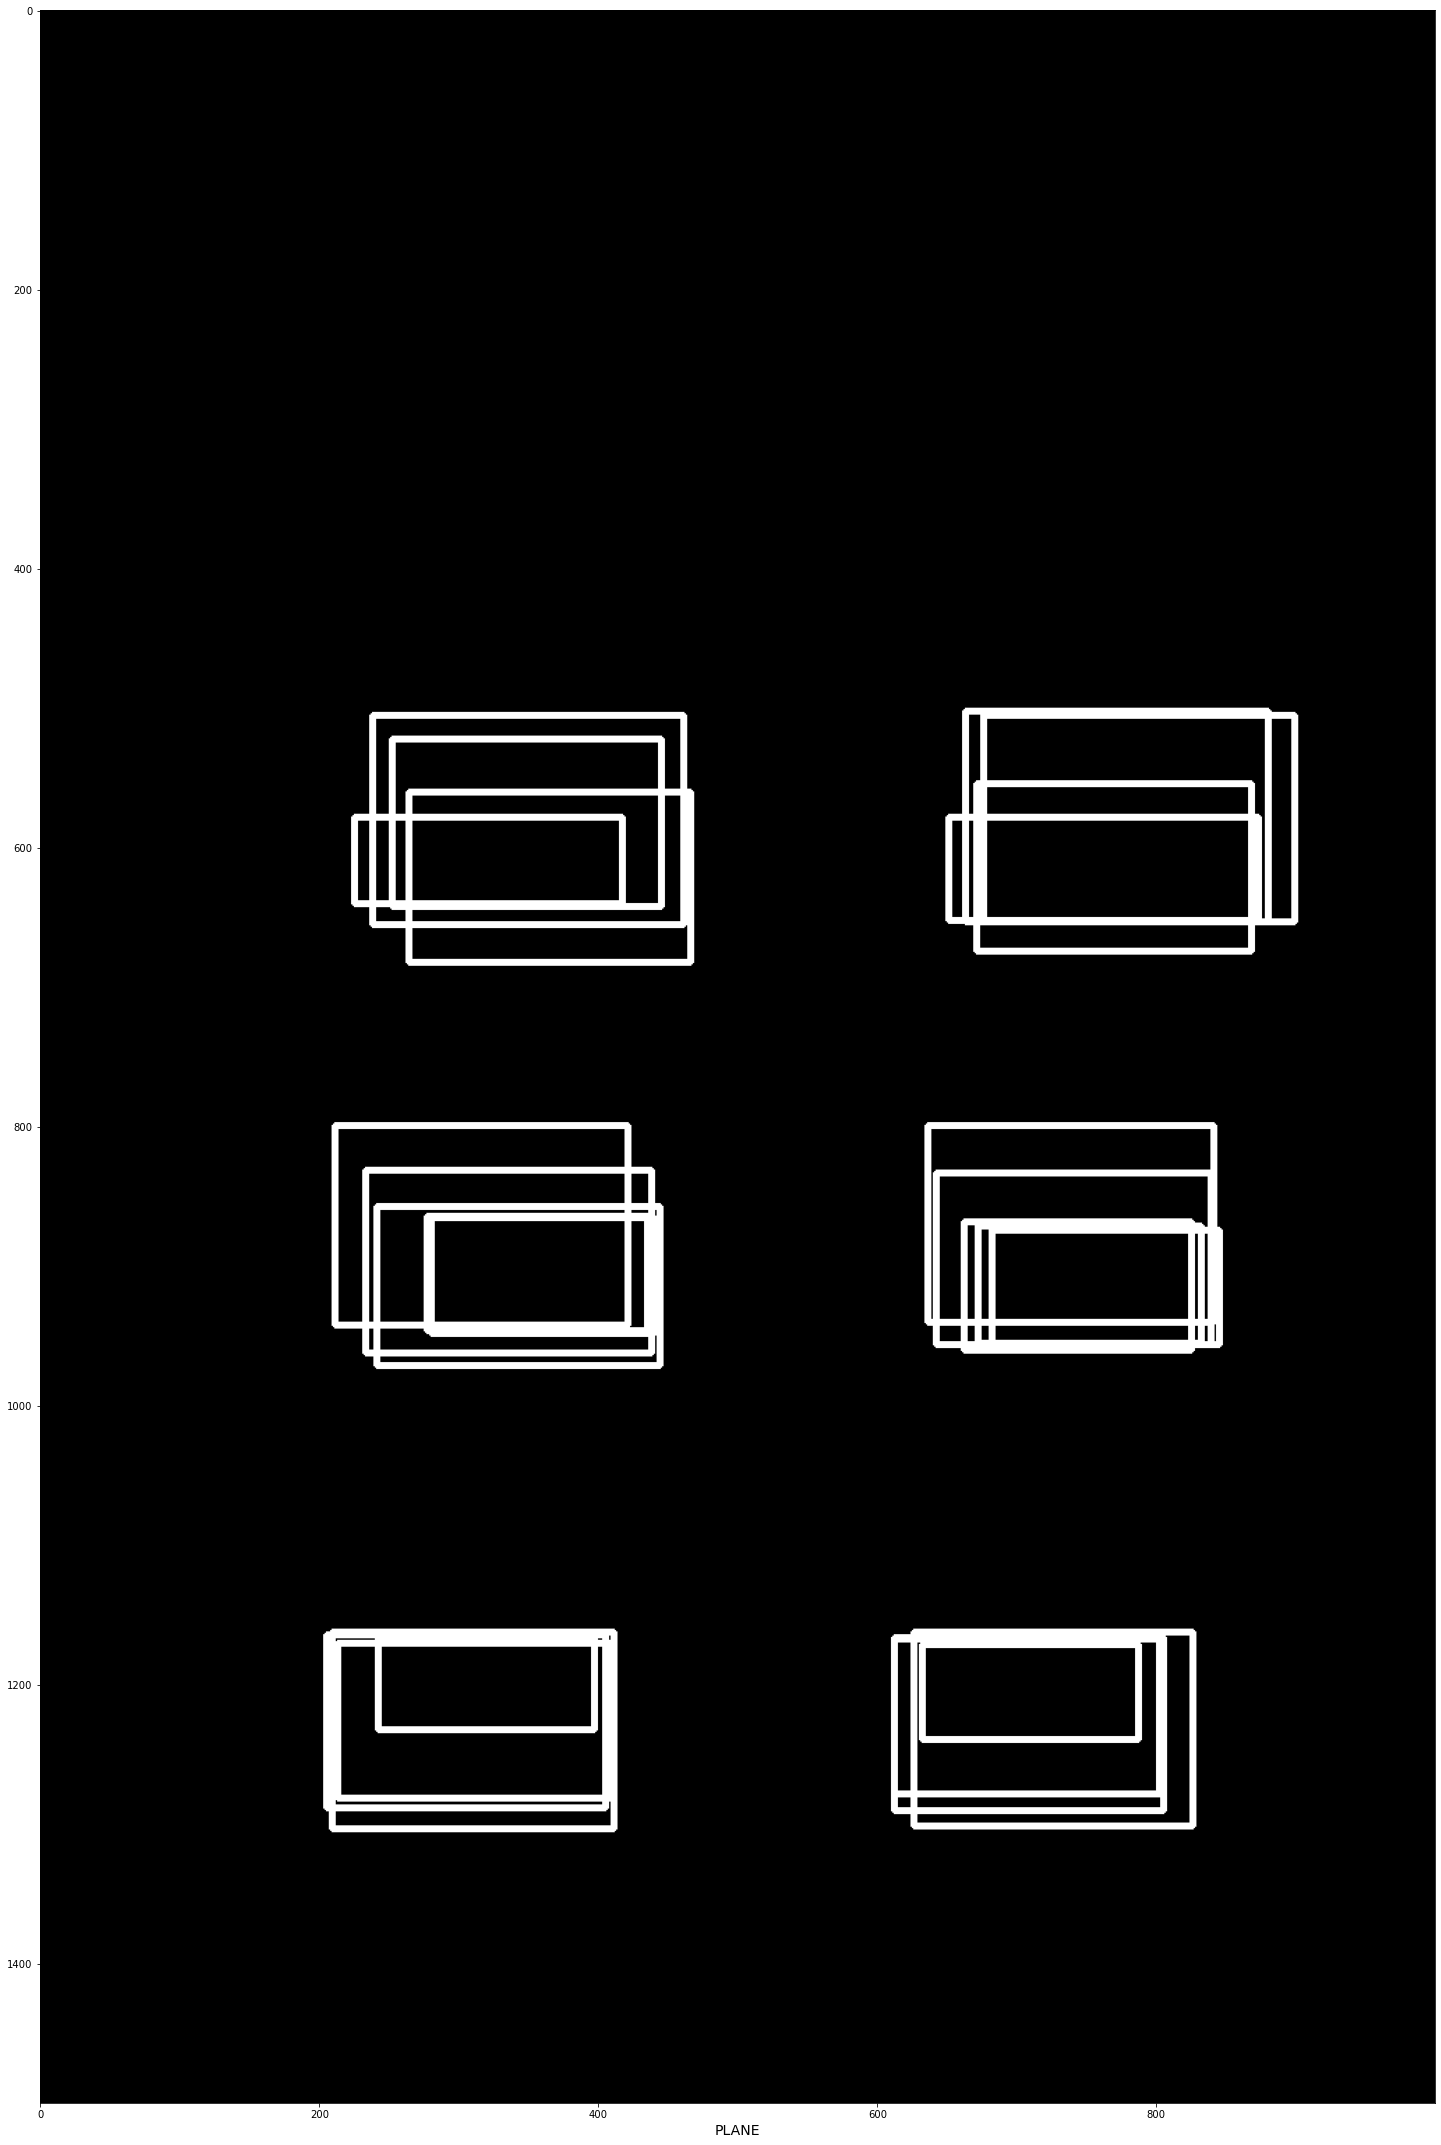

before NMS: [[ 209 1162  411 1303]
 [ 626 1162  826 1301]
 [ 612 1166  805 1290]
 [ 205 1164  405 1288]
 [ 213 1170  408 1281]
 [ 612 1167  802 1278]
 [ 632 1171  787 1239]
 [ 242 1165  397 1232]
 [ 211  799  421  942]
 [ 636  799  841  940]
 [ 233  843  438  974]
 [ 642  845  839  968]
 [ 241  869  444  983]
 [ 662  880  825  972]
 [ 651  590  873  664]
 [ 225  590  417  652]
 [ 682  874  845  956]
 [ 280  865  440  948]
 [ 676  505  899  653]
 [ 252  522  445  642]
 [ 672  871  832  955]
 [ 277  864  435  946]
 [ 238  505  461  655]
 [ 663  502  880  653]
 [ 264  572  466  694]
 [ 671  566  868  686]]


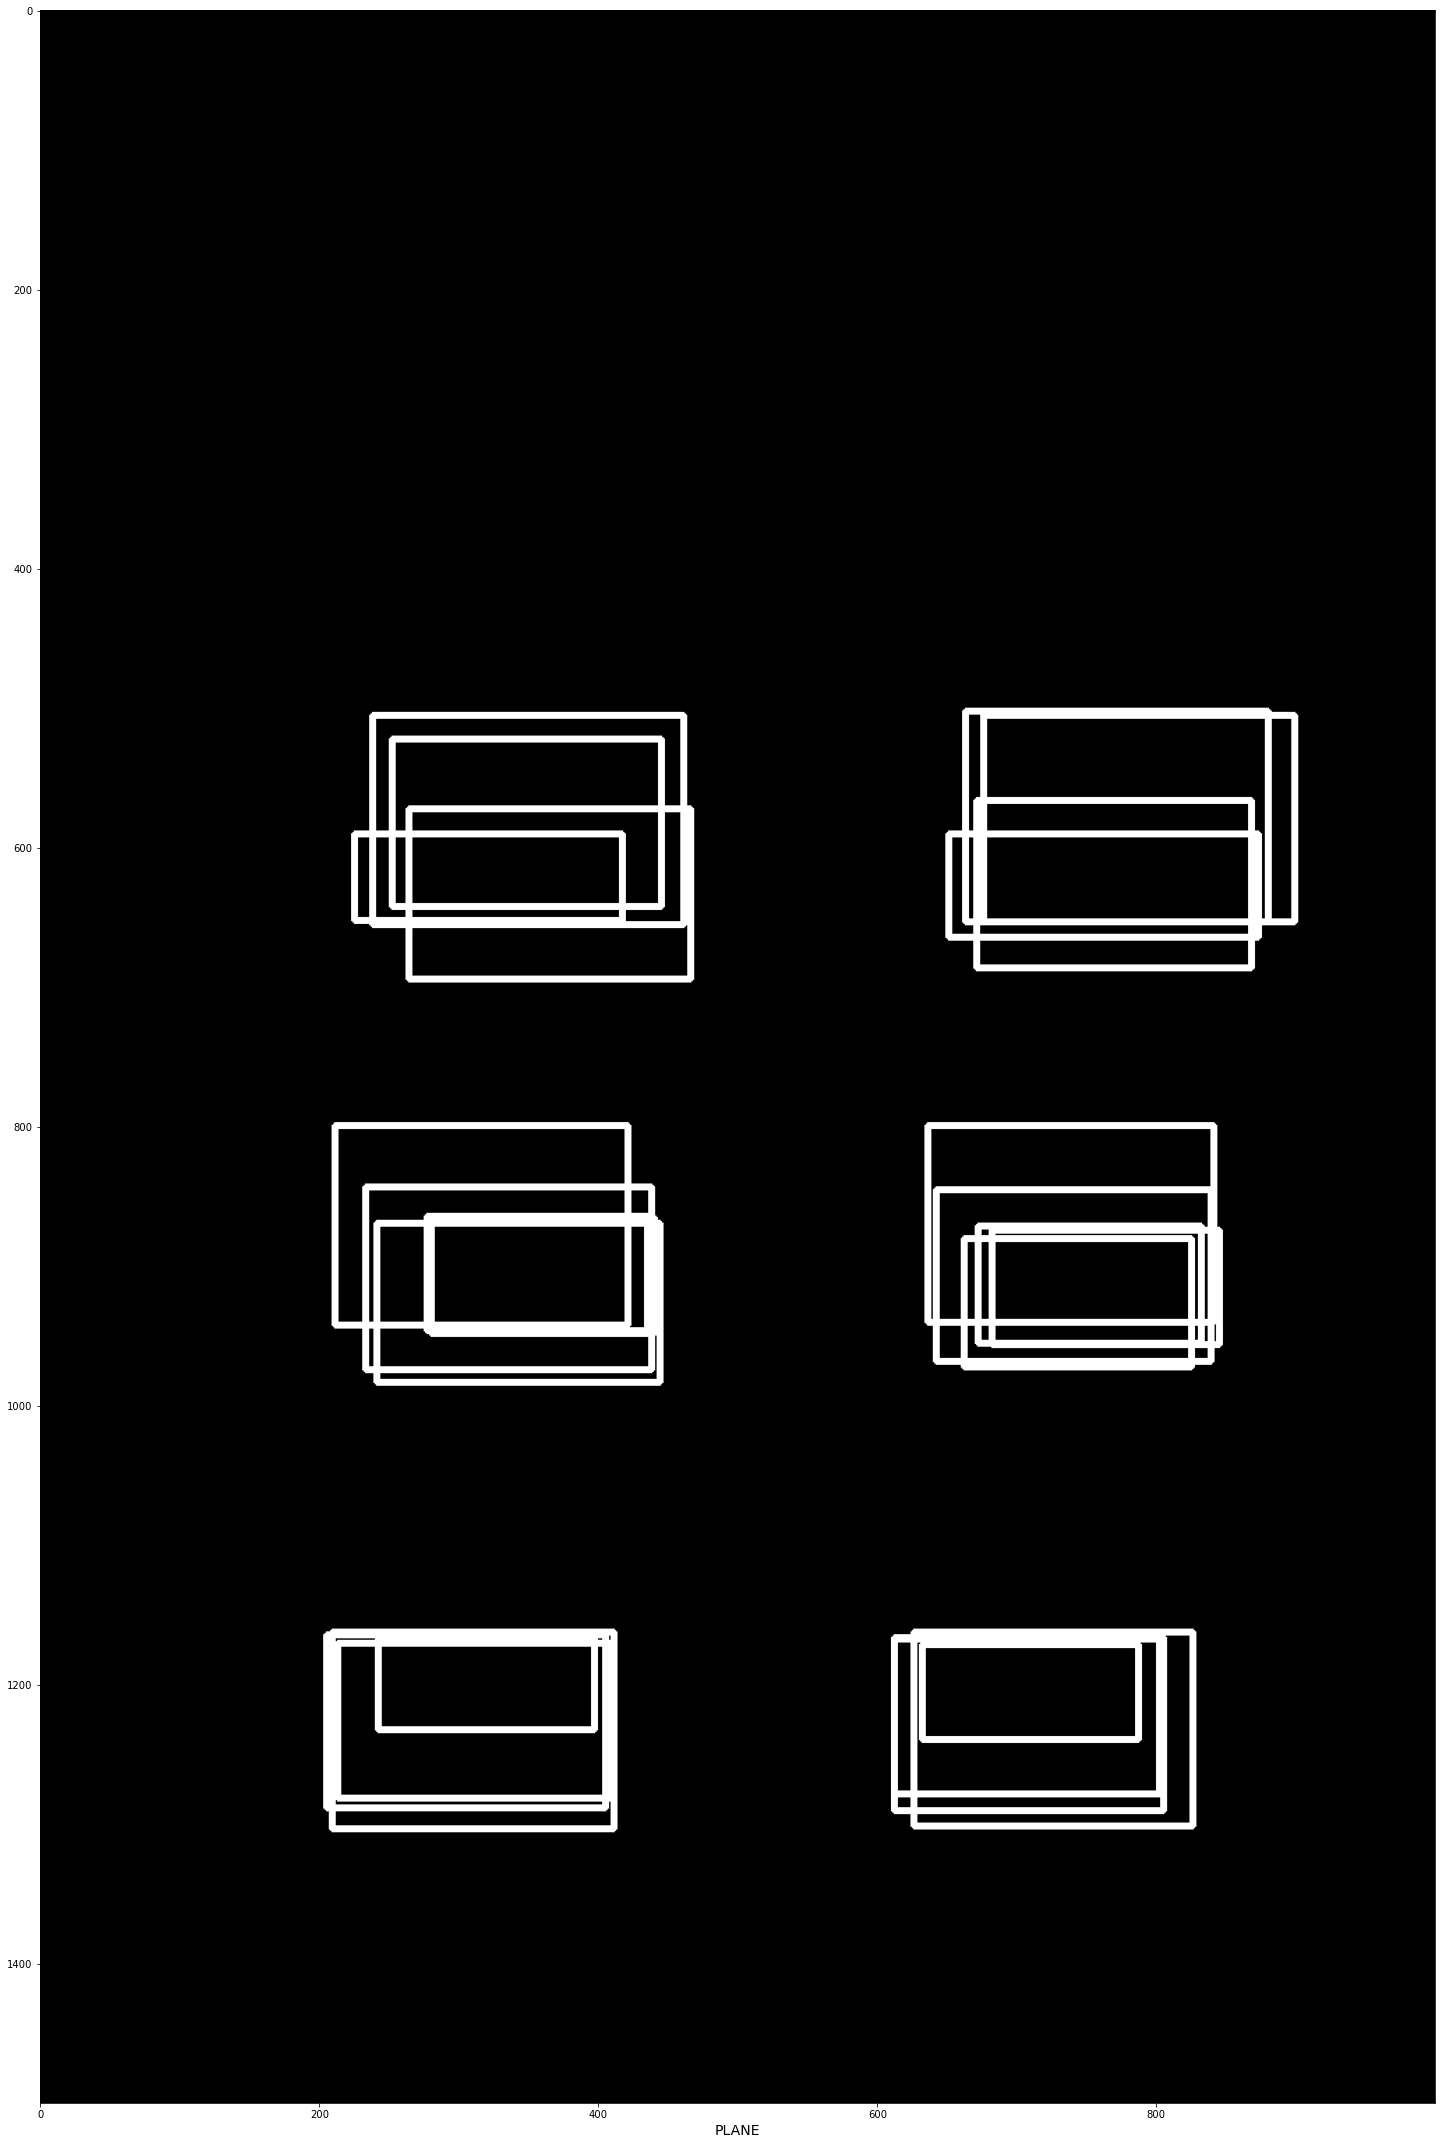

(26, 4)
after NMS: [[ 209 1162  411 1303]
 [ 626 1162  826 1301]
 [ 241  869  444  983]
 [ 662  880  825  972]
 [ 264  572  466  694]
 [ 671  566  868  686]]
(6, 4)


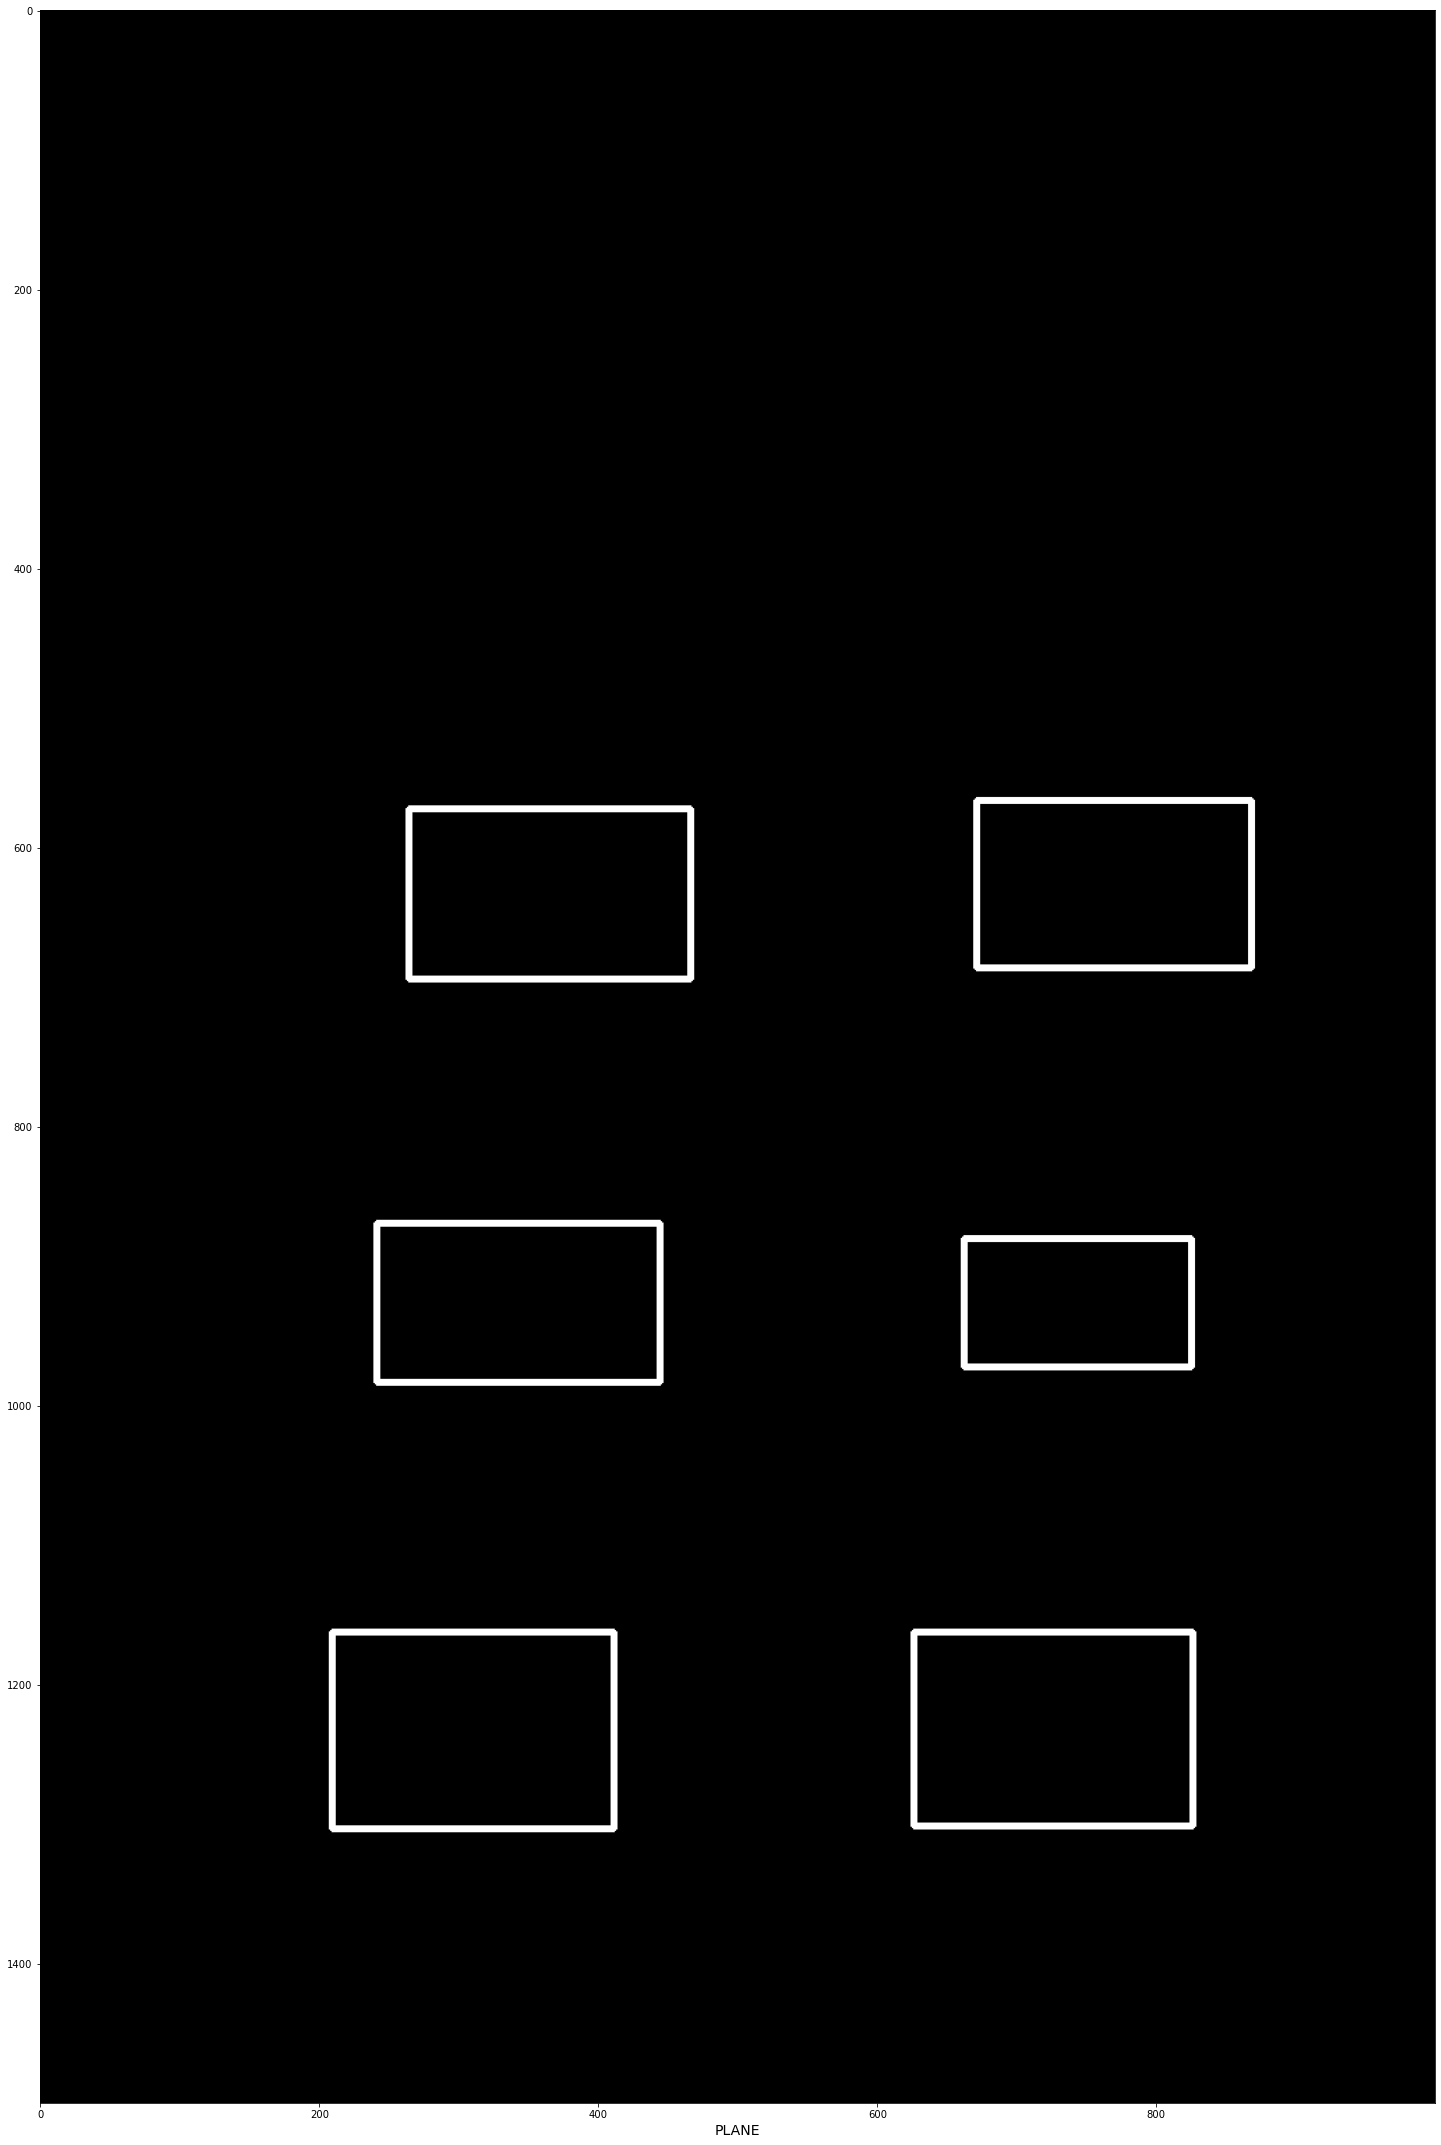

Total no. of windows in seq: 6
yAvg Heights: [267.5 268.5 574.  574.  867.  874. ]
avgStoreyHeights:  [268.0, 574.0, 870.5]
StoreyCount after running post processing module:  3
storeyHeights are: [267.5, 574.0, 867.0]
finallist 9
Total no. of windows in seq: 6
StoreyCount: 3
storeyHeights: [267.5, 574.0, 867.0]
FinalBoxes: [[ 209 1162  411 1303]
 [ 626 1162  826 1301]
 [ 241  869  444  983]
 [ 662  880  825  972]
 [ 264  572  466  694]
 [ 671  566  868  686]]
FinalBoxes (in list): [array([ 209, 1162,  411, 1303]), array([ 626, 1162,  826, 1301]), array([241, 869, 444, 983]), array([662, 880, 825, 972]), array([264, 572, 466, 694]), array([671, 566, 868, 686])]


In [21]:
# Approach 2: Counting Windows using an approximate 2D plane
## Pasting windows on an approximate 2D plane using Triangulation

## INITIALIZED VARIABLES
verticalPlane = np.zeros((1500,1000,3),np.uint8)
#imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\005\\images\\"
#coordFilePath = '..\\win_det_heatmaps\coordinatesFromPostProcessing-5-shufflenet.csv'

#imgPath = '/home/src21/Downloads/Bakul-All/005/images'
#coordFilePath = './coordinatesFromPostProcessing-2new-shufflenet.csv'

verticalPlaneCopy = np.copy(verticalPlane)
focalLength = 920 # in pixels
depth = 700 # in cm
nmsThresh = 0

## HEIGHT INFO OF SEQUENCE
# height_info_1 = [60, 110, 230, 330, 380, 420, 450, 480, 510, 530, 560, 580, 590, 600, 610, 670, 750, 780, 800, 850, 910, 950, 1000]
#height_info = [170, 220, 350, 420, 500, 560, 640, 700, 740, 800, 860, 910, 960, 1000]
height_info = [160, 240, 330, 500, 580, 660, 730, 740, 910]
# height_info_4 = [90, 160, 210, 270, 330, 380, 400, 520, 580, 620, 650, 700, 760, 840, 890, 940, 980, 1000]
# height_info_2 = [50, 90, 140, 200, 230, 310, 340, 360, 420, 450, 510, 590, 640, 670, 720, 750, 780, 810, 920, 950, 970, 990]
# height_info_3 = [70, 120, 150, 170, 200, 310, 330, 390, 430, 470, 500, 520, 550, 600, 630, 690, 720, 750, 800, 860]
print("Height Info Size:", len(height_info))

## Loading Coords from CSV File & Mapping to all 4 coords of Windows logic

def loadCoordsFromCSV(filePath):
    with open(filePath, newline='') as f:
        csvread = csv.reader(f)
#         print(csvread)
        batch_data = list(csvread)

    batch_data_int = []
    for inner_list in batch_data:
        innet_out_list = []
        for string in inner_list:
            innet_out_list.append(int(float(string)))
        batch_data_int.append(innet_out_list)

    FinalList = []
    for i in range(len(batch_data_int)):
        el = batch_data_int[i]
        elChunks = [el[x:x+4] for x in range(0, len(el), 4)]
        newElChunks = elChunks.copy()
        for i in range(len(elChunks)):
            chunk = elChunks[i]
            newChunk = chunk.copy()

            newChunk.insert(2, chunk[0])
            newChunk.insert(3, chunk[3])
            newChunk.insert(6, chunk[2])
            newChunk.insert(7, chunk[1])
            newElChunks[i] = newChunk
        perImageCoords = np.array(newElChunks)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        FinalList.append(perImageCoords)

    print("Final list:", FinalList)
    print("Final list size:", len(FinalList))
    return FinalList

## Here input is in form of list of sX, sY, eX, eY
## Eg: input = [[[s1,s2, e1,e2], [s1, s2, e1, e2]],   [[s3,s4,e3,e4],[s3,s4,e3,e4]]]
def mapToAll4Coords(input):
    inputInListOfLists = [arr.tolist() for arr in input]
    finalListMappedWithAll4Coords = []
    for image in inputInListOfLists:
        finalSubList = []
        imageClone = image.copy()
        for i in range(len(image)):
            window = image[i]
            windowClone = window.copy()
            windowClone.insert(2, window[0])
            windowClone.insert(3, window[3])
            windowClone.insert(6, window[2])
            windowClone.insert(7, window[1])
            imageClone[i] = windowClone
        perImageCoords = np.array(imageClone)
        perImageCoords = perImageCoords.reshape(-1,4,2)
        finalListMappedWithAll4Coords.append(perImageCoords)
    
    return finalListMappedWithAll4Coords

## Eg to test mapToAll4Coords()
input = [np.array([[107, 225, 255, 332]]), np.array([[100, 295, 255, 407]]), np.array([[125, 455, 275, 550], [92, 17, 255, 165]])]

input_Arr = np.array(input)
print(input_Arr)
mapped4Coords = mapToAll4Coords(input)
print(mapped4Coords)
print(mapped4Coords[0].shape)

## Loading coords from CSV File
FinalList = loadCoordsFromCSV(coordFilePath)

## Plane Mapping, NMS and Storey Logic Functions

# FOV = 82.6 degrees, imgDim = 720*960, FocalLength = 410 pixels

def mapToVerticalPlane(focalLength, depth, boundingBoxes, height, verticalPlane, img,i):
    mappedBoundingBoxes = []
    heightOfPlane = verticalPlane.shape[0]
    h, w, c = img.shape
    for box in boundingBoxes:
        sX, sY, eX, eY = box
        print(box)
        
        sY = h/2 - sY
        eY = h/2 - eY
        
        #sY = h/2 - sY - y_corrections[i]
        #eY = h/2 - eY - y_corrections[i]
        
        mappedSX, mappedSY, mappedEX, mappedEY = sX, int(heightOfPlane - ((sY*depth/focalLength) + y_corrections[i] + height)), eX, int(heightOfPlane - ((eY*depth/focalLength) + y_corrections[i] + height))
        
        print("mapped:" + str(mappedSX) + " " +  str(mappedSY)  + " " + str(mappedEX) + " " + str(mappedEY))
#         verticalPlane[mappedSY:mappedEY, mappedSX:mappedEX] = [255,255,255]
        cv2.rectangle(verticalPlane, (mappedSX, mappedSY), (mappedEX, mappedEY), (255, 255, 255), 4)
        
        mappedBoundingBoxes.append((mappedSX, mappedSY-int(y_corrections[i]), mappedEX, mappedEY-int(y_corrections[i])))
    return mappedBoundingBoxes
        

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
#         print("overlap: ", overlap)
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

############### Calculating storey #####################
def calculateStoreys(coords, heightOfPlane = 1500):
    yTop = coords[:,1]
    yBottom = coords[:,3]
    yAvg = (yTop + yBottom)/2
    storeyCount = 1 if len(coords) > 0 else 0
    index = 0
    storeyHeights = [heightOfPlane - yAvg[0]] if len(coords) > 0 else []
#     print('yTop:', yTop)
#     print('yAvg:', yAvg)
#     print('yBottom:', yBottom)    
    print('yAvg Heights:', heightOfPlane - yAvg)

    singleStoreyHeight = []
    avgStoreyHeights = []
    
    for i in range(len(coords)):
        if (((yAvg[index] > yTop[i]) and (yAvg[index] < yBottom[i])) or 
            ((yTop[index] > yTop[i]) and (yTop[index] < yBottom[i]))  or
            ((yBottom[index] > yTop[i]) and (yBottom[index] < yBottom[i]))):
            singleStoreyHeight.append(heightOfPlane - yAvg[i])
            continue
        else:
            avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
            singleStoreyHeight = []
            index = i
            storeyCounted = False
            for j in range(i):  
                if (((yAvg[index] > yTop[j]) and (yAvg[index] < yBottom[j])) or 
                    ((yTop[index] > yTop[j]) and (yTop[index] < yBottom[j])) or
                    ((yBottom[index] > yTop[j]) and (yBottom[index] < yBottom[j]))):
                    storeyCounted = True
                    break
            if(storeyCounted == False):
                storeyHeights.append(heightOfPlane - yAvg[index])
                singleStoreyHeight.append(heightOfPlane - yAvg[i])
                storeyCount+=1
                
    avgStoreyHeights.append(sum(singleStoreyHeight)/len(singleStoreyHeight))
    print('avgStoreyHeights: ', avgStoreyHeights)
    print('StoreyCount after running post processing module: ', storeyCount)
    print("storeyHeights are:", storeyHeights)
    return storeyCount, storeyHeights, avgStoreyHeights

def plotBoxes(verticalPlane, boxes):
    for box in boxes:
        sX, sY, eX, eY = box
        cv2.rectangle(verticalPlane, (sX, sY), (eX, eY), (255, 255, 255), 4)
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlane, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()

## Running Vertical Plane Mapping



# grab the paths to the input images and initialize our images list
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(imgPath)))
images = []
# loop over the image paths, load each one, and add them to our
# images to stitch list
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
    #print(image.shape)
    images.append(image)
    print(imagePath)

windowCount = len(FinalList[0])
print("startWindowCount:", windowCount)
allMappedBoxes = []
## MAIN LOOP ##
for i in range(len(images)):
    img1 = images[i]
    
#     print(img1.shape)
    # read images and transform them to grayscale
    # Make sure that the train image is the image that will be transformed
    # Opencv defines the color channel in the order BGR 
    # Transform it to RGB to be compatible to matplotlib
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
#     img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(16,9))
    ax1.imshow(img1, cmap="gray")
    ax1.set_xlabel("img1", fontsize=14)
    plt.show()
    
    ## Preparing Binary Mask and mapping bounding box coordinates
    ## COORDS1 and COORDS2 : WOULD COME FROM TEXT FILEW
    coords1 = FinalList[i]
#     coords2 = FinalList[i+1]
    
    padding = 0

    ## Commented as the coords would come from recorded text File.
    pick1 = mapToPickv1(coords1, padding)
#     pick2 = mapToPickv1(coords2, padding)
    
    mappedBoxes = mapToVerticalPlane(focalLength,depth,pick1,height_info[i], verticalPlaneCopy, img1,i)
    allMappedBoxes = allMappedBoxes + mappedBoxes
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(25, 500))
    ax1.imshow(verticalPlaneCopy, cmap="gray")
    ax1.set_xlabel("PLANE", fontsize=14)
    plt.show()
    
## NMS
print("before NMS:", np.array(allMappedBoxes))
plotBoxes(np.copy(verticalPlane), allMappedBoxes)
print(np.array(allMappedBoxes).shape)

finalBoxes = non_max_suppression_fast(np.array(allMappedBoxes), nmsThresh)
print("after NMS:", finalBoxes)
print(finalBoxes.shape)
plotBoxes(np.copy(verticalPlane), finalBoxes)
print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
storeyCount, storeyHeights,avgStoreyHeights = calculateStoreys(finalBoxes)

len(images)

print('finallist',len(FinalList))

## Final Result of Vertical Plane Mapping Approach 

print("Total no. of windows in seq: " + str(finalBoxes.shape[0]))
print("StoreyCount:", storeyCount)
print("storeyHeights:", storeyHeights)

print("FinalBoxes:", finalBoxes)
print("FinalBoxes (in list):", list(finalBoxes))

imu correction <br>
differences bw storey heights across vertical seq of windows <br>
differences bw centres of the windows average (intra sequence) across vertical seqs <br>
differences bw windows of a single vertical set <br>
    Height Differences between storeys of a single vertical sequence <br>
    
averge building height and storey height across all seq for final ans <br>
plot imu height data and all seq height data to compare <br>

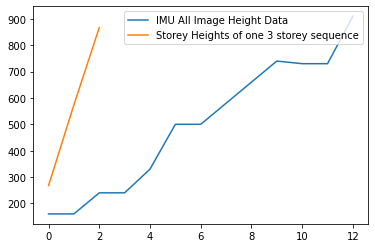

In [13]:
# imu plot data for this seq
plt.figure()
plt.plot(heights_allImages, label = 'IMU All Image Height Data')
plt.plot(storeyHeights, label = 'Storey Heights of one ' + str(storeyCount) + ' storey sequence')
plt.legend()
plt.show()

In [14]:
# Height Differences between storeys of a single vertical sequence
np.diff(np.array(storeyHeights))

array([306.5, 293. ])